In [0]:
Do not run this file

In [0]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38'

In [0]:
#Title: Energy forecasting using LSTM Networks
#Author: Arslan Ahmed (arslan.m.ahmed@gmail.com)
#Date: 18th Aug, 2018

#import all packages that we may need

import sys 
 # linear algebra
from scipy.stats import randint
import pandas as pd # data processing
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn import preprocessing # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.ensemble import ExtraTreesClassifier
from scipy import signal
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from keras.regularizers import L1L2

import statsmodels.tsa.stattools as tsa
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

## for Deep-learing:
import keras
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from pandas import concat
import matplotlib.dates as md
from keras.layers.normalization import BatchNormalization

from tsfresh import extract_relevant_features
from keras import regularizers
from pandas.plotting import autocorrelation_plot
from sklearn.linear_model import LinearRegression
import time

import pulp
from pulp import *

C:\Users\Arslan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Arslan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [0]:
# def test_stationarity(timeseries):
    
#     #Determing rolling statistics
#     rolmean = timeseries.rolling(24*2).mean()
    
#     rolstd = timeseries.rolling(24*2).std()

#     #Plot rolling statistics: 
#     plt.figure(figsize=(30,8))
#     orig = plt.plot(timeseries, color='blue',label='Original')
#     mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
#     #Perform Dickey-Fuller test:
#     print ('Results of Dickey-Fuller Test:')
#     dftest = tsa.adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)

In [0]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.5, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(30,8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(series[window:],'bo-', label="Actual values")
    plt.plot(rolling_mean, "go-", label="Rolling mean trend")
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.legend(loc="best", fontsize=27,framealpha=0.5)
    plt.grid(True)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        plt.tick_params(axis='both', which='major', labelsize=30)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            #anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            #anomalies[series<lower_bond] = series[series<lower_bond]
            #anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(series[series>upper_bond], "ro", markersize=10)
            plt.plot(series[series<lower_bond], "ro", markersize=10)
    

    return rolling_mean

In [0]:
#function to convert time series data to apply supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
#read energy data

df_e = pd.read_csv('MIT_weather_energy__Apt2_3years_realData.csv', parse_dates=['time'], infer_datetime_format=True, na_values=['nan','?'], index_col='time')

In [0]:
#select data from 
df=df_e['2015-07-28':'2015-12-31'].copy()
no_of_timesteps=3*24*2
print_till=3*24*2

In [0]:
df=df.resample('30min').mean()

In [0]:
# print(df.shape)

In [0]:
df.iloc[:,0] *= 1000

In [0]:
#display first five rows
# df.head()

In [0]:
no_of_features=len(df.columns)

In [0]:
##describe the data to see mean, std, percentiles etc..
# df.describe()

In [0]:
# plt.figure(figsize=(30,8))
# plt.plot (df.Apt2, 'go-')

In [0]:
##plotting all columns with respect to time for original data
#for j in range(0,no_of_features):        
#        plt.figure(figsize=(20,5))
#        df.iloc[:,j].plot(legend=True)

In [0]:
##histograom of original data
#for j in range(0,no_of_features):        
#        plt.figure(figsize=(10,5))
#        df[df.columns[j]].plot.hist(legend=True)    

In [0]:
## Correlations matrix of original data
#plt.figure(figsize=(5,5))
#plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
#plt.title('Correlation matrix', size=10)
#plt.colorbar()
#plt.show()

In [0]:
#removing outliers
df[df.Apt2 > df.Apt2.quantile(.99)]=np.nan #data above 90 percentile will be filled with NaN

In [0]:
# remove NaNs
#print (df.isnull().sum())
df=df.interpolate(method='linear')
#df=df.fillna(method='pad')

In [0]:
# another sanity check to make sure that there are no nan
df.isnull().sum()

Apt2                   0
temperature            0
humidity               0
visibility             0
apparentTemperature    0
pressure               0
windSpeed              0
cloudCover             0
windBearing            0
precipIntensity        0
dewPoint               0
precipProbability      0
dtype: int64

In [0]:
df_copy_before_smoothing=df.copy();

In [0]:
#df.describe()

In [0]:
##plotting all columns with respect to time after removing outliers and missing values
#for j in range(0,no_of_features):        
#        plt.figure(figsize=(20,5))
#        df.iloc[:,j].plot(legend=True)

In [0]:
##histogram for data after removing outliers and missing values
#for j in range(0,no_of_features):        
#        plt.figure(figsize=(10,5))
#        df[df.columns[j]].plot.hist(legend=True)    

In [0]:
## Correlations matrix of data with removed outliers and missing values
#plt.figure(figsize=(5,5))
#plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
#plt.title('Correlation matrix', size=10)
#plt.colorbar()
#plt.show()

In [0]:
#drop features that are correlated with each other and those which are constants (for LSTM)
df=df.drop(df.columns[2:], axis=1)

In [0]:
#revised no. of features after dropping correlated features
no_of_features=len(df.columns)

In [0]:
## Correlations matrix of data after dropping correlated features
#plt.figure(figsize=(5,5))
#plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
#plt.title('Correlation matrix', size=10)
#plt.colorbar()
#plt.show()

In [0]:
##corelation of all the features (on x-axis) with the target variable Energy (on y-axis) - after removing outliers and missing values
#for j in range(1,no_of_features):
#    sns.jointplot(x=df.columns[j],y=df.columns[-1],data=df)

In [0]:
## Ana Maria - are these plots correct??
##density plot for data after pre-processing (removing outliers and missing values, correlated and constant columns)
#for j in range(0,no_of_features):        
#        plt.figure(figsize=(10,5))
#        df[df.columns[j]].plot.density(legend=True)
#        print(df[df.columns[j]].describe())

In [0]:
# df.describe()

In [0]:
#Exponential smoothing
# alpha=plotMovingAverage(df.Apt2, 4)
df.Apt2=df.Apt2.rolling(2).mean()
df=df[1:] #remove top row because they are now NaN after exponential smooting filter of 4

In [0]:
# #decomposition to remove seasonal and trend component
# decompfreq =24*2;
# resultAdd = sm.tsa.seasonal_decompose(df.Apt2,freq=decompfreq,model='add')

In [0]:
# plt.figure(figsize=(30,8))
# plt.plot (resultAdd.observed, 'bo-')
# plt.plot (resultAdd.trend,  'ro-')
# plt.plot (resultAdd.resid, 'mo-')
# plt.plot (resultAdd.seasonal, 'go-')

# plt.tick_params(axis='both', which='major', labelsize=30)

In [0]:
# #Whether or not use decomposed residual (omment/unomment this line accordingly)

# df_decomposed=(df.Apt2-resultAdd.resid)
# # df_stationary=df.diff(1).dropna()


# # df.Apt2=df_decomposed
# # df=df.dropna()

# # plt.figure(figsize=(30,8))
# # plt.plot (df_decomposed['2015-12-01':'2015-12-07'], 'bo-')
# # plt.tick_params(axis='both', which='major', labelsize=30)


In [0]:
############################      ADD MORE FEATURES     ##############################

df['Day_of_week'] = df.index.weekday.astype(int)
# df["Weekend"] = (df["Day_of_week"] > 5).astype(int)
# df['Day'] = df.index.day.astype(int)
df['Hour'] = df.index.hour.astype(int)

############################      ADD MORE FEATURES     ##############################

In [0]:
# df=pd.get_dummies(df, prefix=['Day_of_week', 'Day','Hour'], columns=['Day_of_week', 'Day','Hour'])

In [0]:
#after adding extracted features
no_of_features=len(df.columns)

In [0]:
# df.head()

In [0]:

# sm.graphics.tsa.plot_acf(df.Apt2, lags=no_of_timesteps)
# # sm.graphics.tsa.plot_pacf(df.Apt2, lags=no_of_timesteps)

In [0]:
#data scaling from 0 to 1 of original data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

In [0]:
reframed = series_to_supervised(scaled, no_of_timesteps, 1)
# print(reframed.head())

In [0]:
# drop columns after var1(t)
reframed.columns.get_loc("var1(t)")
reframed=reframed.drop(reframed.columns[reframed.columns.get_loc("var1(t)")+1:], axis=1)

In [0]:
# print(reframed.head())
# print(reframed.shape)

In [0]:
# reframed['var1(t)']=df.Apt2[24:].values

In [0]:
feature_select=False
show_shortlisted_features=False
if feature_select:
    show_shortlisted_features=False

In [0]:
reframed_original=reframed.copy()
#instead of selected features through features extraction, we select all the features except lags_to_select from the end
# lags_to_select=1*no_of_features
# reframed = reframed_original.values[:, :-lags_to_select+1]
# names_col = reframed_original.columns.values[:-lags_to_select+1]
# reframed = pd.DataFrame(reframed, columns=names_col)
# reframed['var1(t)']=reframed_original.values[:, -1]

In [0]:
# reframed.head()

In [0]:
if feature_select:
    # split into input and output
    X = reframed.values[:,:-1]
    y = reframed.values[:,-1]
    # perform feature selection
    rfe = RFE(RandomForestRegressor(n_estimators=10, verbose=1), verbose =2, step=0.25) #step corresponds to the percentage (rounded down) of features to remove at each iteration
    rfe.fit(X, y)

In [0]:

if feature_select:
    print("Optimal number of features : %d" % rfe.n_features_)
    # report selected features
    print('Selected Features:')
    names = reframed.columns.values[0:-1]
    selected_features=[]
    for i in range(len(rfe.support_)):
        if rfe.support_[i]:
            print(names[i])
            selected_features.append(names[i])
    # plot feature rank
    plt.figure(figsize=(30,8))
    ticks = [i for i in range(len(names))]
    plt.bar(ticks, rfe.ranking_)
    plt.xticks(ticks, names)
    plt.show()

In [0]:
if feature_select:
    reframed_selected=reframed[selected_features].copy()
    reframed_selected['var1(t)']=reframed[['var1(t)']]
else:
    reframed_selected=reframed.copy()

In [0]:
if show_shortlisted_features:
    # split into input and output
    X = reframed_selected.values
    y = reframed_selected.values
    # fit random forest model
    model = RandomForestRegressor(n_estimators=10, verbose=1)
    model.fit(X, y)
    # show importance scores
#     print(model.feature_importances_)

if show_shortlisted_features:
    # plot importance scores of shortlisted features
    plt.figure(figsize=(30,8))
    names = reframed_selected.columns.values[0:-1]
    ticks = [i for i in range(len(model.feature_importances_))]
    plt.bar(ticks, model.feature_importances_)
    plt.xticks(ticks, names)
    plt.xticks(rotation=90)
    plt.show()

In [0]:
reframed_selected['Time'] = pd.to_datetime(df.index[no_of_timesteps:])   
reframed_selected.set_index('Time',inplace=True)
reframed_original['Time'] = pd.to_datetime(df.index[no_of_timesteps:])   
reframed_original.set_index('Time',inplace=True)

In [0]:
reframed_selected_for_opt=reframed_selected.copy() #create copy for use by optimiation at the end
# reframed_selected.head()
#reframed_original.head()

In [0]:
alpha=len((reframed_selected[:'2015-11']).index)
beta=len((reframed_selected[:'2015-12-3']).index)

In [0]:
n_train_time = alpha; # no. of half-hours used for training.....
original_n_train_time=n_train_time;
testing_rows=beta-alpha;#half-hours to predict

batch_size_fit=int(no_of_timesteps/2)

In [0]:
train = reframed_selected.values[:n_train_time, :] #train data including dependent and independent variables
# split into target variable and independent variables
train_X, train_y = train[:, :-1], train[:, -1]


In [0]:
#testing_rows=reframed_selected.shape[0]-original_n_train_time-1
test1 = reframed_selected.values[n_train_time:n_train_time+testing_rows, :] #copy of original test data to measure accuracy at the end
test_y1 = test1[:, -1] #target variable in the test data
test_X1 = test1[:,:-1]

In [0]:
########################    COPY FOR ENSEMBLE          ################
train_RF=train;

########################    COPY FOR ENSEMBLE          ################

In [0]:
#to unscale later

x_max=df.Apt2.max()
x_min=df.Apt2.min()
test_y1_un_scaled=test_y1*(x_max-x_min)+x_min

In [0]:
######################          LSTM   MODEL  ###################################

In [0]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

#test_X1 reshaped for validation data only
test_X1_VD = test_X1.reshape((test_X1.shape[0], 1, test_X1.shape[1]))

print(train_X.shape)

(5903, 1, 576)


In [0]:
dropout_value=0.2

In [0]:
#LSTM model
###############  WARNING ################
#either use this block or the next block, not both at a time

number_of_neurons=int(train_X.shape[2]/4)

start = time.time()

model = Sequential()
model.add(LSTM(int(train_X.shape[2]/2),  dropout=0, recurrent_dropout=0, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))

# model.add(LSTM(90, activation='tanh', recurrent_activation='tanh', dropout=dropout_value, recurrent_dropout=dropout_value,return_sequences=True))

# model.add(LSTM(50, activation='tanh', recurrent_activation='tanh', dropout=dropout_value, recurrent_dropout=dropout_value,return_sequences=True))

model.add(LSTM(int(train_X.shape[2]/4),  dropout=dropout_value, recurrent_dropout=dropout_value,return_sequences=True))

model.add(LSTM(int(train_X.shape[2]/8),dropout=dropout_value, recurrent_dropout=dropout_value))

model.add(Dense(1, activation='linear'))

adam=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
sgd = keras.optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=adam, metrics=['mse'])
# fit network

history = model.fit(train_X, train_y, epochs=50, batch_size=batch_size_fit, verbose=2, shuffle=True,validation_split=0.06,validation_data=(train_X[-print_till:], train_y[-print_till:]))
#history = model.fit(train_X, train_y, epochs=25, batch_size=batch_size_fit, verbose=2, shuffle=True,validation_split=0.06,validation_data=(test_X1_VD, test_y1))

end = time.time()

Train on 5903 samples, validate on 144 samples
Epoch 1/25
 - 6s - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.0338 - val_mean_squared_error: 0.0338
Epoch 2/25
 - 3s - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 3/25
 - 3s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 4/25
 - 4s - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 5/25
 - 4s - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0154 - val_mean_squared_error: 0.0154
Epoch 6/25
 - 3s - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 7/25
 - 3s - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 8/25
 - 3s - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 9/25
 - 3s - loss: 0.0129 - mean_squared_er

In [0]:
print("Execution time: %i sec"  %(end - start))

Execution time: 92 sec


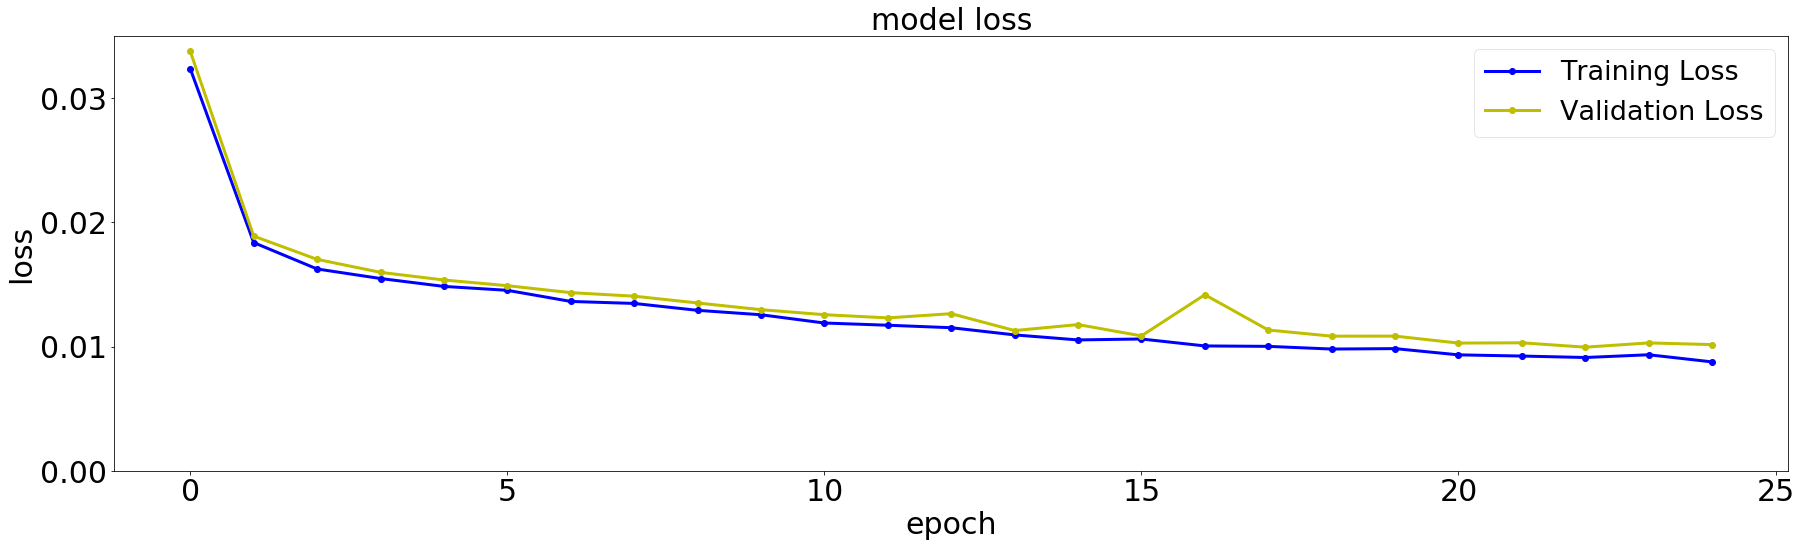

In [0]:
#udnerfit: training loss is lower than the validation loss, and the validation loss has a trend that suggests further improvements are possible.
#good fit: train and validation loss decrease and stabilize around the same point.
#over fit: performance on the train set is good and continues to improve, whereas performance on the validation set improves to a point and then begins to degrade
plt.figure(figsize=(30,8))
plt.plot(history.history['loss'][:],'bo-', label='Training Loss', linewidth=3)
plt.plot(history.history['val_loss'][:], 'yo-' , label='Validation Loss', linewidth=3)
plt.title('model loss', fontsize=30)
plt.ylabel('loss', fontsize=30)
plt.xlabel('epoch', fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)
plt.ylim(ymin=0)
plt.tick_params(axis='both', which='major', labelsize=30)
# plt.savefig('Loss Curve_adam.pdf', bbox_inches='tight')
plt.show()

In [0]:
########################        TRAINING DATA FOR OTHER MODELS    #####################

train_RF_X, train_RF_y = train_RF[:, :-1], train_RF[:, -1]

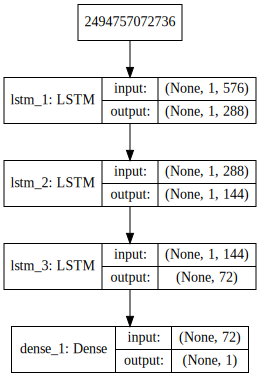

In [0]:
### Plot your model 

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [0]:
######################                LR MODEL  ###################################

start = time.time()

model_LR = LinearRegression()

model_LR.fit(train_RF_X, train_RF_y)

end = time.time()

print("Execution time: %i sec"  %(end - start))

Execution time: 0 sec


In [0]:
######################  MODELLING DONE - NOW APPLY  ###############################

###################################################################################
###################################################################################


In [0]:
################
#                                              TRAINING
################

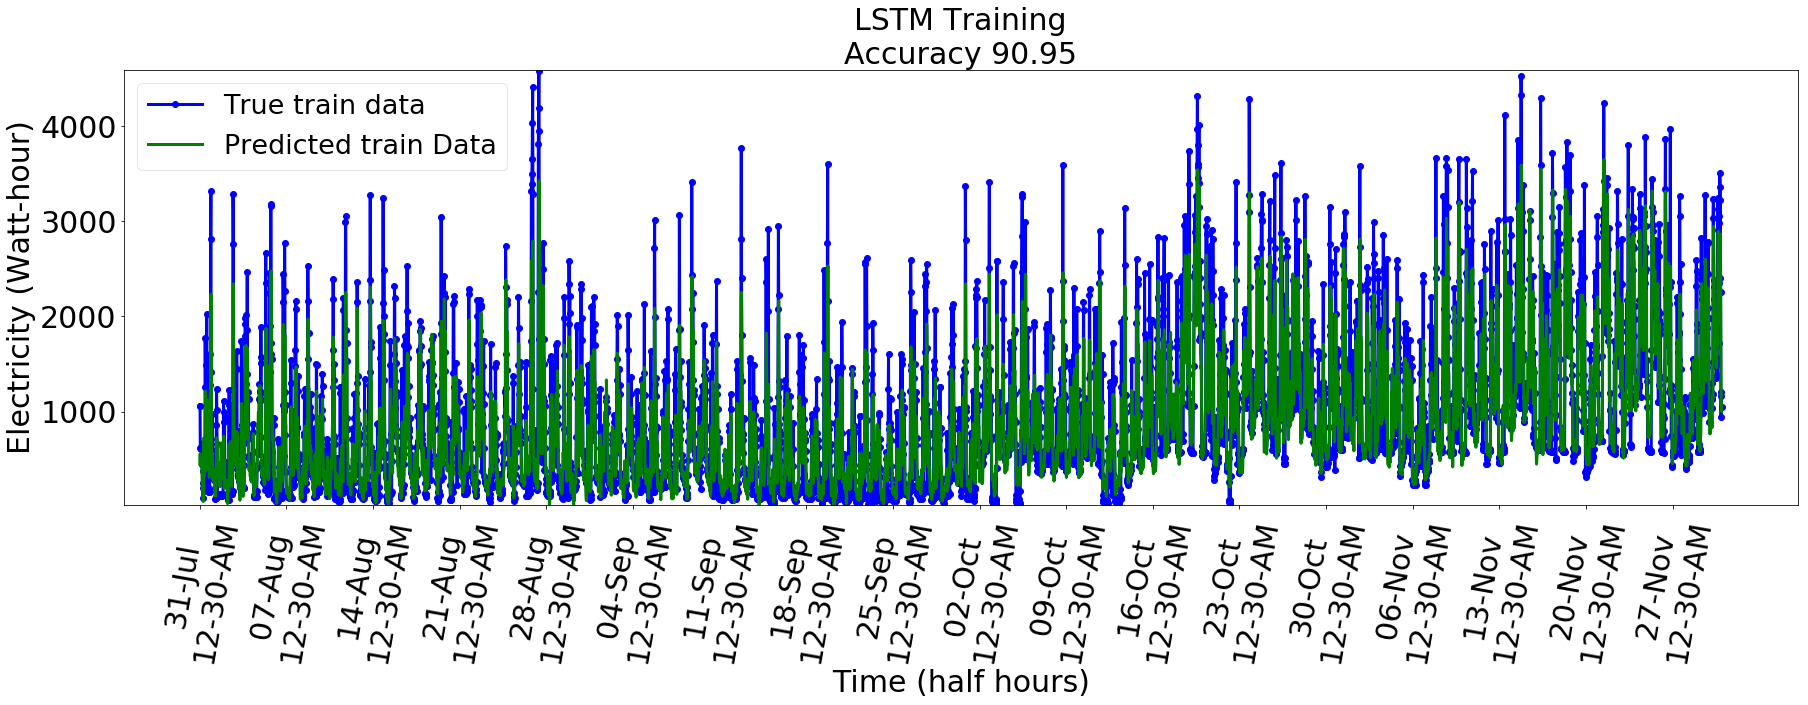

r2 score:  0.7204290944952707
Mean Absolute Error:  0.0619753130423111
Root Mean Square Error:  0.09051882239299472


In [0]:
#                                     LSTM Training Plot

pred_train_x = model.predict(train_X, batch_size=batch_size_fit)
train_y_un_scaled=train_y*(x_max-x_min)+x_min
pred_train_x_un_scaled=pred_train_x*(x_max-x_min)+x_min

mae=mean_absolute_error(train_y, np.roll(pred_train_x, 0))
rmse=np.sqrt(mean_squared_error(train_y, np.roll(pred_train_x, 0)))
r2score=r2_score(train_y, np.roll(pred_train_x, 0))

plt.figure(figsize=(30,8))
plt.plot(train_y_un_scaled,'bo-', label='True train data', linewidth=3)
plt.plot(np.roll(pred_train_x_un_scaled, -0),'g-',label='Predicted train Data', linewidth=3)
plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)

x=np.arange(0,len(train_y_un_scaled),7*24*2) #take every y_th element
y=reframed_selected_for_opt[:alpha].index.strftime('%d-%b\n%I-%M-%p')[::7*24*2] #double colon prints every y_th element from the list / array
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

plt.ylim(ymin=x_min,ymax=x_max)
plt.title('LSTM Training\nAccuracy %0.2f' % (100*(1-rmse)), fontsize=30)
plt.legend(loc='upper left', fontsize=27,framealpha=0.5)
#plt.savefig('5a.pdf', bbox_inches='tight')
plt.show()
rmse_train=np.sqrt(mean_squared_error(train_y_un_scaled, np.roll(pred_train_x_un_scaled, 0)))
# plt.savefig('Thesis_Results_MIT_LSTM_1days_30min_medium_train.pdf', bbox_inches='tight')
print("r2 score: " , r2score)
print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

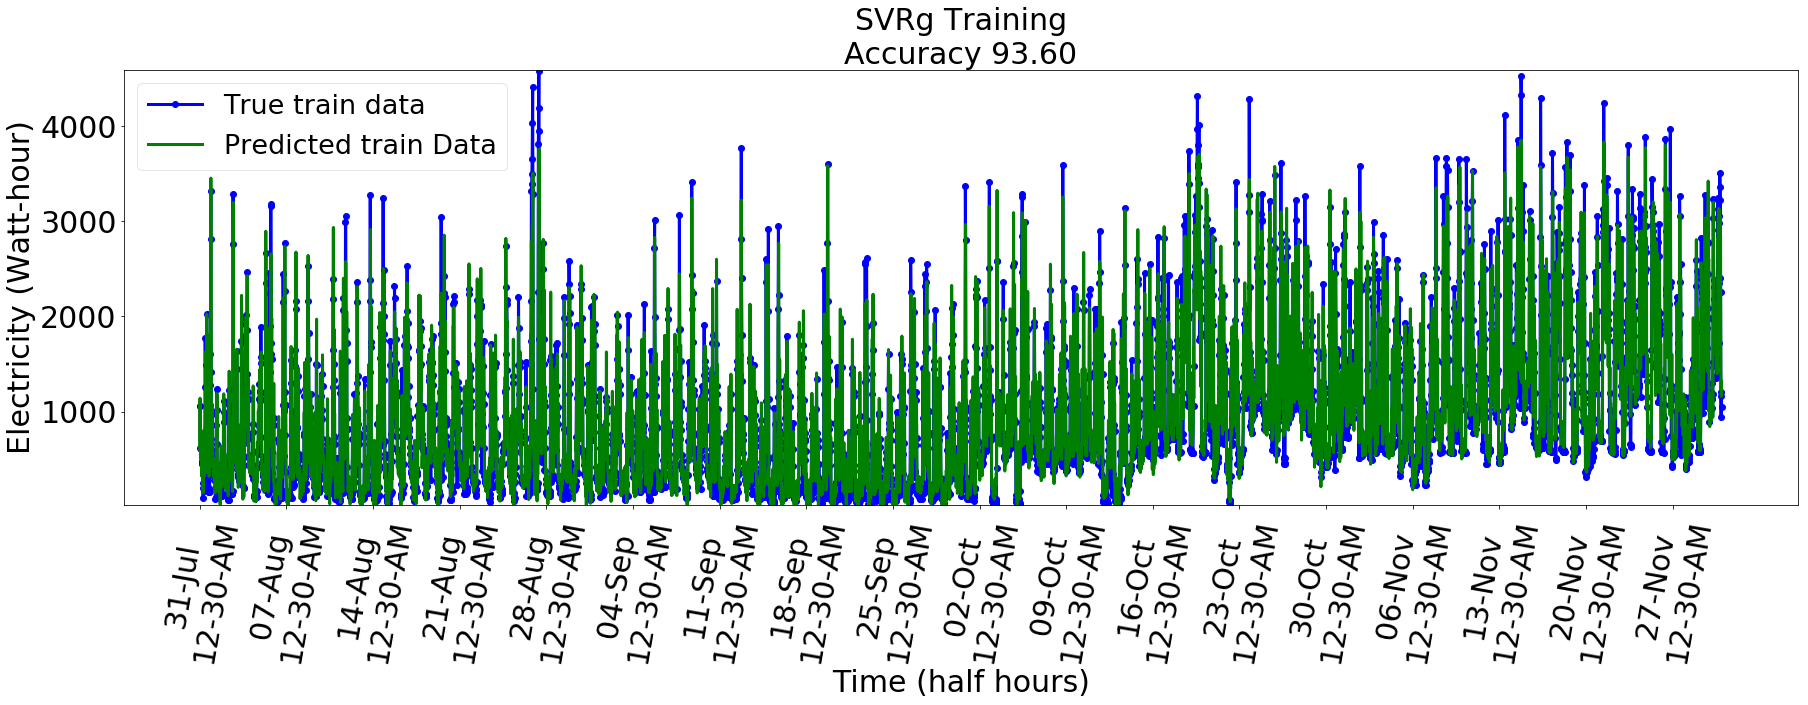

r2 score:  0.8337800225605853
Mean Absolute Error:  0.04308839428040693
Root Mean Square Error:  0.06402158246791305


In [0]:
#                                     LR Training Plot


pred_train_x_LR = model_LR.predict(train_RF_X)
train_y_un_scaled_LR=train_RF_y*(x_max-x_min)+x_min
pred_train_x_un_scaled_LR=pred_train_x_LR*(x_max-x_min)+x_min

mae=mean_absolute_error(train_y_un_scaled_LR, np.roll(pred_train_x_un_scaled_LR, 0))
mae = (mae-x_min)/(x_max-x_min)

rmse=np.sqrt(mean_squared_error(train_y_un_scaled_LR, np.roll(pred_train_x_un_scaled_LR, 0)))
rmse = (rmse-x_min)/(x_max-x_min)

r2score=r2_score(train_y_un_scaled_LR, np.roll(pred_train_x_un_scaled_LR, 0))

plt.figure(figsize=(30,8))
plt.plot(train_y_un_scaled_LR,'bo-', label='True train data', linewidth=3)
plt.plot(np.roll(pred_train_x_un_scaled_LR, -0),'g-',label='Predicted train Data', linewidth=3)
plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)

x=np.arange(0,len(train_y_un_scaled),7*24*2) #take every y_th element
y=reframed_selected_for_opt[:alpha].index.strftime('%d-%b\n%I-%M-%p')[::7*24*2] #double colon prints every y_th element from the list / array
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

plt.ylim(ymin=x_min,ymax=x_max)
plt.title('SVRg Training\nAccuracy %0.2f' % (100*(1-rmse)), fontsize=30)
plt.legend(loc='upper left', fontsize=27,framealpha=0.5)
#plt.savefig('5a.pdf', bbox_inches='tight')
plt.show()
rmse_train=np.sqrt(mean_squared_error(train_y_un_scaled, np.roll(pred_train_x_un_scaled, 0)))
# plt.savefig('Thesis_Results_MIT_LSTM_1days_30min_medium_train.pdf', bbox_inches='tight')
print("r2 score: " , r2score)
print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

In [0]:
#######################              LSTM    ROLLING         ########################


pred_list=[]; #predicted values that will replace the original test_y values
opt_list=[]; #predicted values that will replace the original test_y values
copy_to_reset_reframed_original=reframed_original.copy()
copy_to_reset_reframed_selected=reframed_selected.copy()

#Re-modelling for Testing Data
for j in range(0,testing_rows):
#     print('Loop # ',j)
    test = reframed_selected.values[n_train_time:n_train_time+1, :]
    test_X = test[:, :-1]
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    yhat = model.predict(test_X,batch_size=1, verbose=0)
    
    if j>18 and j<30:
        yhat_opt=1*yhat;
    else:
        yhat_opt=yhat;
    
    
#     if print_till<=24*2:
#         do_no=24
#     else:
#         do_no=print_till*1/3
    
    if True:
        for k in range(0,len(reframed_original.columns),no_of_features):
            if((k+no_of_features)<(len(reframed_original.columns)-1)):
                reframed_original.values[n_train_time+1,k]=reframed_original.values[n_train_time,(k+no_of_features)];
        temp1=reframed_original.values[n_train_time+1,(len(reframed_original.columns)-1-no_of_features)]
        reframed_original.values[n_train_time+1,(len(reframed_original.columns)-1-no_of_features)]=yhat_opt;

     #  reframed_original.values[n_train_time+1,(len(reframed_original.columns)-1-no_of_features)]=yhat; #if one feaeture and one timestep used

        if feature_select:
            reframed_selected=reframed_original[selected_features]
            reframed_selected['var1(t)']=reframed_original[['var1(t)']]
        else:
    #         reframed_selected = reframed_original.values[:, :-lags_to_select+1]
    #         names_col = reframed_original.columns.values[:-lags_to_select+1]
    #         reframed_selected = pd.DataFrame(reframed_selected, columns=names_col)
    #         reframed_selected['var1(t)']=reframed_original.values[:, -1]
            reframed_selected=reframed_original


    pred_list=np.append(pred_list,yhat)
    opt_list=np.append(opt_list,yhat_opt)
#     print(reframed_selected[n_train_time:n_train_time+1])
#     print("yhat: ",yhat)
    n_train_time=n_train_time+1
    
n_train_time=original_n_train_time
reframed_original=copy_to_reset_reframed_original.copy()
reframed_selected=copy_to_reset_reframed_selected.copy()

r2 score:  0.4079813878965991
Mean Absolute Error:  0.08690417281753345
Root Mean Square Error:  0.12686017902925592


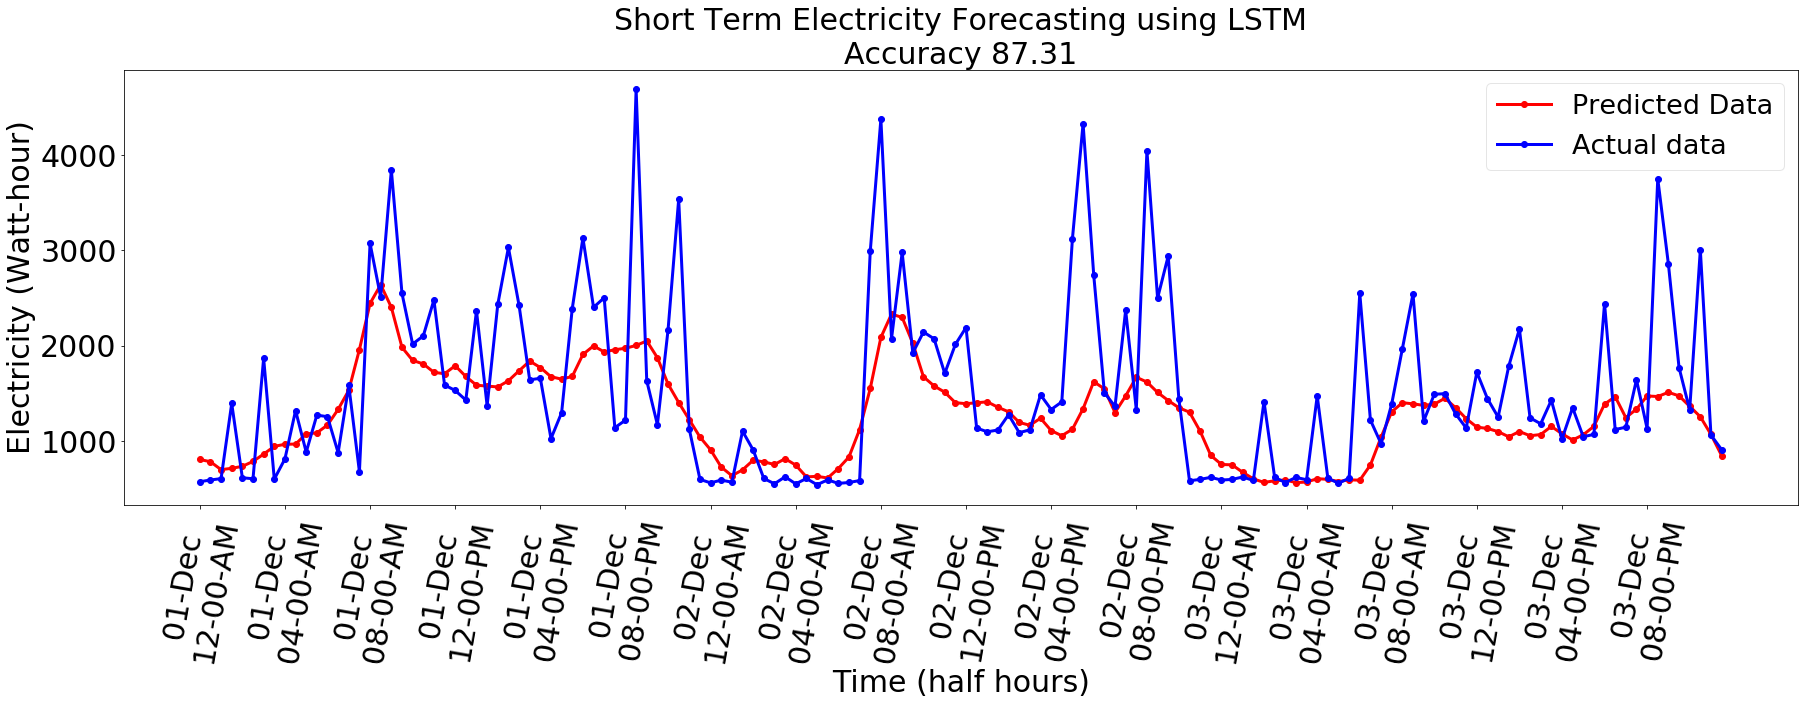

In [0]:
#######################              LSTM    PRINT         ########################

pred_list_un_scaled=pred_list*(x_max-x_min)+x_min
opt_list_un_scaled=opt_list*(x_max-x_min)+x_min

mae=mean_absolute_error(test_y1_un_scaled[0:print_till], np.roll(pred_list_un_scaled[0:print_till], -0))
mae = (mae-x_min)/(x_max-x_min)

rmse=np.sqrt(mean_squared_error(test_y1_un_scaled[0:print_till], np.roll(pred_list_un_scaled[0:print_till], -0)))
rmse = (rmse-x_min)/(x_max-x_min)

r2score=r2_score(test_y1_un_scaled[0:print_till], np.roll(pred_list_un_scaled[0:print_till], -0))

plt.figure(figsize=(30,8))
plt.plot(np.roll(pred_list_un_scaled[0:print_till], -0),'ro-',label='Predicted Data', linewidth=3)
# plt.plot(test_y1_un_scaled[0:print_till],'bo-', label='True data', linewidth=3)
plt.plot(df_copy_before_smoothing.Apt2['2015-12-01':].values[0:print_till],'bo-', label='Actual data', linewidth=3)

plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)


x=np.arange(0,len(test_y1_un_scaled[0:print_till]),8) #take every y_th element
y=reframed_selected_for_opt[alpha:alpha+print_till].index.strftime('%d-%b\n%I-%M-%p')[::8] #double colon prints every y_th element from the list / array
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=0,ymax=x_max)
plt.title("Short Term Electricity Forecasting using LSTM\nAccuracy %0.2f" % (100*(1-rmse)), fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)

# plt.savefig('Thesis_Results_MIT_LSTM_1days_30min_medium_test.pdf', bbox_inches='tight')
print("r2 score: " , r2score)
print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

In [0]:
#######################              LR    ROLLING         ########################

pred_list_LR=[]; #predicted values that will replace the original test_y values
copy_to_reset_reframed_original=reframed_original.copy()
copy_to_reset_reframed_selected=reframed_selected.copy()

#Re-modelling for Testing Data
for j in range(0,testing_rows):
#     print('Loop # ',j)
    test = reframed_selected.values[n_train_time:n_train_time+1, :]
    test_X = test[:, :-1]
    yhat = model_LR.predict(test_X)

    if True :
        for k in range(0,len(reframed_original.columns),no_of_features):
            if((k+no_of_features)<(len(reframed_original.columns)-1)):
                reframed_original.values[n_train_time+1,k]=reframed_original.values[n_train_time,(k+no_of_features)];
        temp1=reframed_original.values[n_train_time+1,(len(reframed_original.columns)-1-no_of_features)]
        reframed_original.values[n_train_time+1,(len(reframed_original.columns)-1-no_of_features)]=yhat;

     #  reframed_original.values[n_train_time+1,(len(reframed_original.columns)-1-no_of_features)]=yhat; #if one feaeture and one timestep used

        if feature_select:
            reframed_selected=reframed_original[selected_features]
            reframed_selected['var1(t)']=reframed_original[['var1(t)']]
        else:
    #         reframed_selected = reframed_original.values[:, :-lags_to_select+1]
    #         names_col = reframed_original.columns.values[:-lags_to_select+1]
    #         reframed_selected = pd.DataFrame(reframed_selected, columns=names_col)
    #         reframed_selected['var1(t)']=reframed_original.values[:, -1]
            reframed_selected=reframed_original


    pred_list_LR=np.append(pred_list_LR,yhat)
#     print(reframed_selected[n_train_time:n_train_time+1])
#     print("yhat: ",yhat)
    n_train_time=n_train_time+1
    
n_train_time=original_n_train_time
reframed_original=copy_to_reset_reframed_original.copy()
reframed_selected=copy_to_reset_reframed_selected.copy()

r2 score:  0.5434449340617744
Mean Absolute Error:  0.0857825350983544
Root Mean Square Error:  0.11070131022386107


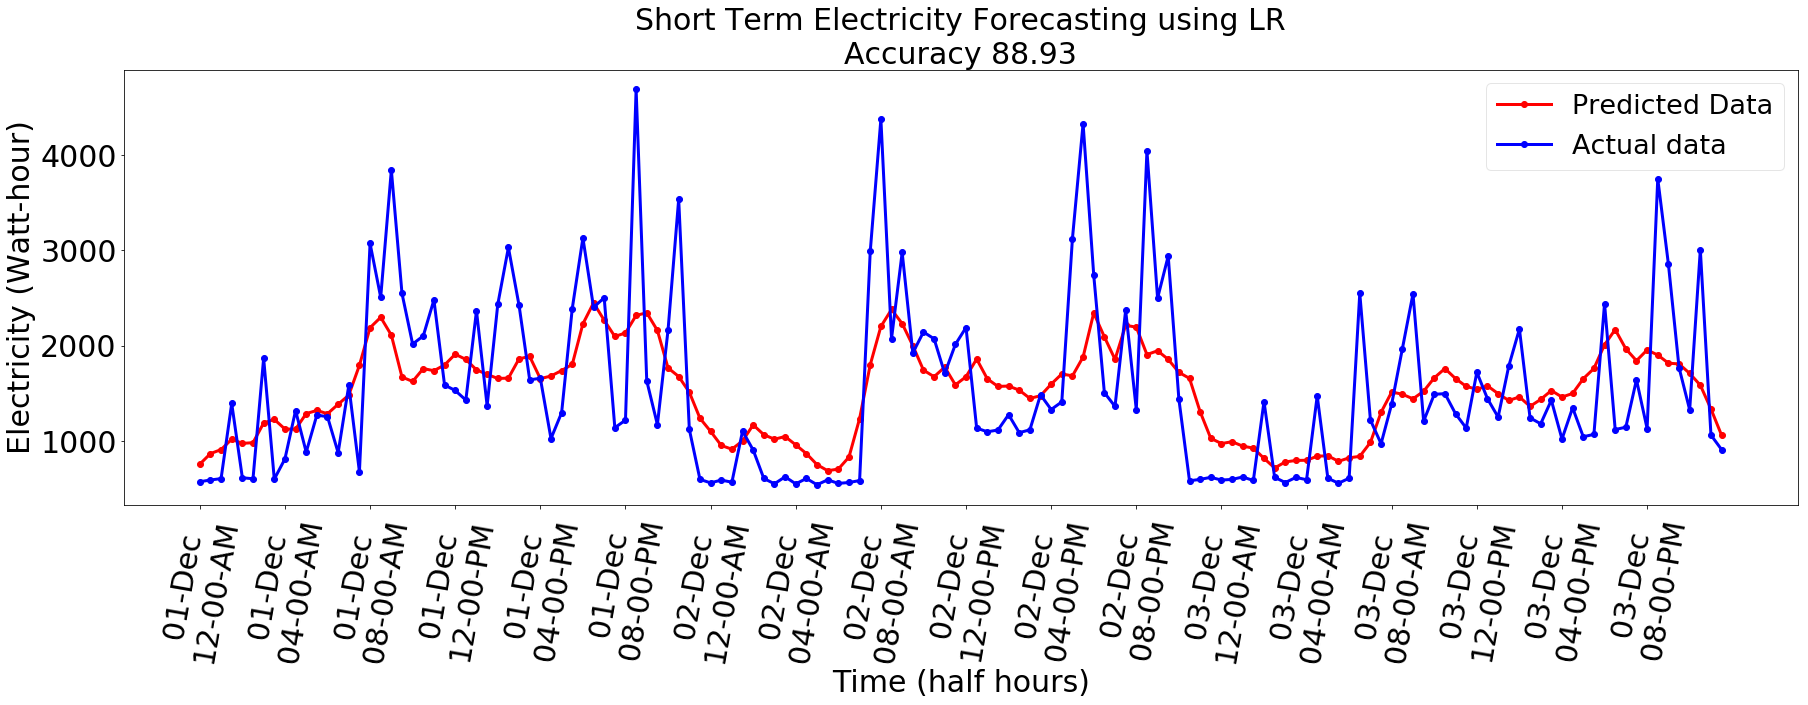

In [0]:
#######################              LR    PRINT         ########################

pred_list_un_scaled_LR=pred_list_LR*(x_max-x_min)+x_min

mae=mean_absolute_error(test_y1_un_scaled[0:print_till], np.roll(pred_list_un_scaled_LR[0:print_till], -0))
mae = (mae-x_min)/(x_max-x_min)

rmse=np.sqrt(mean_squared_error(test_y1_un_scaled[0:print_till], np.roll(pred_list_un_scaled_LR[0:print_till], -0)))
rmse = (rmse-x_min)/(x_max-x_min)

r2score=r2_score(test_y1_un_scaled[0:print_till], np.roll(pred_list_un_scaled_LR[0:print_till], -0))

plt.figure(figsize=(30,8))
plt.plot(np.roll(pred_list_un_scaled_LR[0:print_till], -0),'ro-',label='Predicted Data', linewidth=3)
# plt.plot(test_y1_un_scaled[0:print_till],'bo-', label='True data', linewidth=3)
plt.plot(df_copy_before_smoothing.Apt2['2015-12-01':].values[0:print_till],'bo-', label='Actual data', linewidth=3)

plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)


x=np.arange(0,len(test_y1_un_scaled[0:print_till]),8) #take every y_th element
y=reframed_selected_for_opt[alpha:alpha+print_till].index.strftime('%d-%b\n%I-%M-%p')[::8] #double colon prints every y_th element from the list / array
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=0,ymax=x_max)
plt.title("Short Term Electricity Forecasting using LR\nAccuracy %0.2f" % (100*(1-rmse)), fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)

# plt.savefig('Thesis_Results_MIT_LSTM_1days_30min_medium_test.pdf', bbox_inches='tight')
print("r2 score: " , r2score)
print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

In [0]:
#######################               ENSEMBLE            #############################

In [0]:
df_Ensemble = pd.DataFrame()
df_Ensemble['time']=reframed_selected_for_opt.index[alpha:alpha+print_till]

df_Ensemble['SVRg']=pred_list_un_scaled_LR[:print_till]
df_Ensemble['LSTM']=pred_list_un_scaled[:print_till]

df_Ensemble['actual_test']=test_y1_un_scaled[0:print_till]
# df_Ensemble['actual_test']=df_copy_before_smoothing.Apt2['2015-12-01':].values[0:print_till]

df_Ensemble=df_Ensemble.set_index('time')

#shift LSTM by 1 if True not used in rolling
# df_Ensemble.LSTM=np.roll(df_Ensemble.LSTM, -1)

df_Ensemble.head()

,SVRg,LSTM,actual_test
time,,,
2015-12-01 00:00:00,758.953790,808.210541,590.083055
2015-12-01 00:30:00,869.261231,784.207892,583.708333
2015-12-01 01:00:00,912.019293,701.449837,600.043611
2015-12-01 01:30:00,1020.063482,715.316746,1001.208333
2015-12-01 02:00:00,976.852770,736.334051,1005.813889


In [0]:
######################                LR MODEL      FOR      ENSEMBLING ###############################
split =int(print_till/3);

train_ens_X = df_Ensemble.values[:split,:-1]
train_ens_y = df_Ensemble.values[:split,-1]


test_ens_X = df_Ensemble.values[:,:-1]
test_ens_y = df_Ensemble.values[:,-1]


start = time.time()

model_Ensemble = LinearRegression()
# model_Ensemble = RandomForestRegressor(n_estimators=100, verbose=2)

#best
# model_Ensemble = SVR(kernel='poly', degree=1,verbose=1)   #  C=1e3, gamma=1e-7 is best when testing on whole,  C=1e8, gamma=1e-8 is best when testing on after split (genuine)

model_Ensemble.fit(train_ens_X, train_ens_y)

end = time.time()

print("Execution time: %i sec"  %(end - start))

Execution time: 0 sec


In [0]:
predicted_from_ensemble = model_Ensemble.predict(test_ens_X)

In [0]:
model_Ensemble.coef_

array([0.8846729 , 0.41073966])

In [0]:
# TRAINING ACCURACIES
rmse_LR=np.sqrt(mean_squared_error(test_ens_y[:split], test_ens_X[:split,0]))
rmse_LR = (rmse_LR-x_min)/(x_max-x_min)

rmse_LSTM=np.sqrt(mean_squared_error(test_ens_y[:split:], test_ens_X[:split,1]))
rmse_LSTM = (rmse_LSTM-x_min)/(x_max-x_min)

rmse_Ensemble=np.sqrt(mean_squared_error(test_ens_y[:split], predicted_from_ensemble[:split]))
rmse_Ensemble = (rmse_Ensemble-x_min)/(x_max-x_min)

print("NRMSE_SVRg: ", round(rmse_LR, 4))
print("NRMSE_LSTM: ", round(rmse_LSTM, 4))
print("NRMSE_Ensemble: ", round(rmse_Ensemble, 4))

NRMSE_SVRg:  0.1121
NRMSE_LSTM:  0.1187
NRMSE_Ensemble:  0.1055


In [0]:
# TESTING ACCURACIES
rmse_LR=np.sqrt(mean_squared_error(test_ens_y[split:], test_ens_X[split:,0]))
rmse_LR = (rmse_LR-x_min)/(x_max-x_min)

rmse_LSTM=np.sqrt(mean_squared_error(test_ens_y[split:], test_ens_X[split:,1]))
rmse_LSTM = (rmse_LSTM-x_min)/(x_max-x_min)

rmse_Ensemble=np.sqrt(mean_squared_error(test_ens_y[split:], predicted_from_ensemble[split:]))
rmse_Ensemble = (rmse_Ensemble-x_min)/(x_max-x_min)

print("NRMSE_SVRg: ", round(rmse_LR, 4))
print("NRMSE_LSTM: ", round(rmse_LSTM, 4))
print("NRMSE_Ensemble: ", round(rmse_Ensemble, 4))

NRMSE_SVRg:  0.11
NRMSE_LSTM:  0.1308
NRMSE_Ensemble:  0.1036


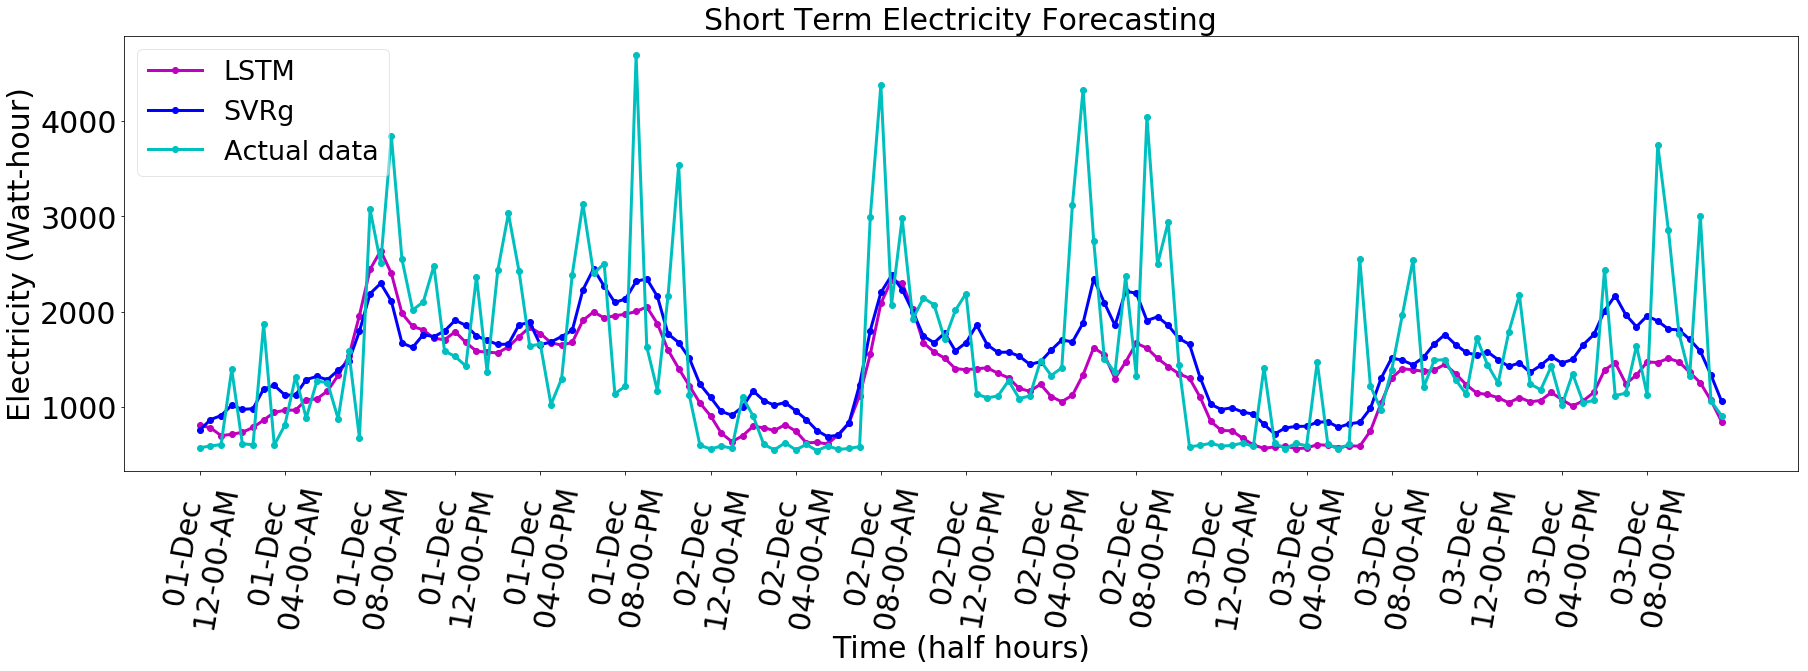

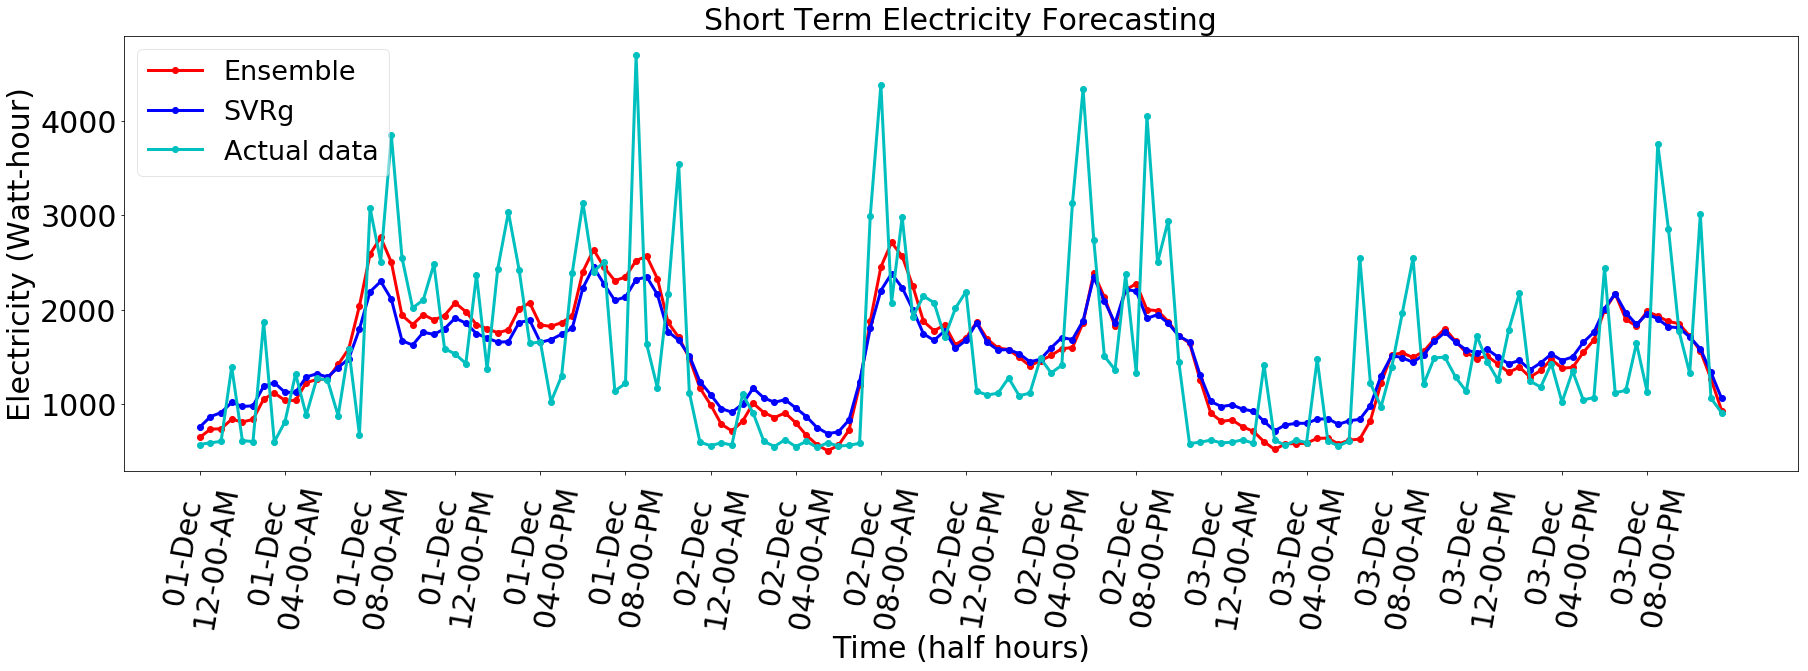

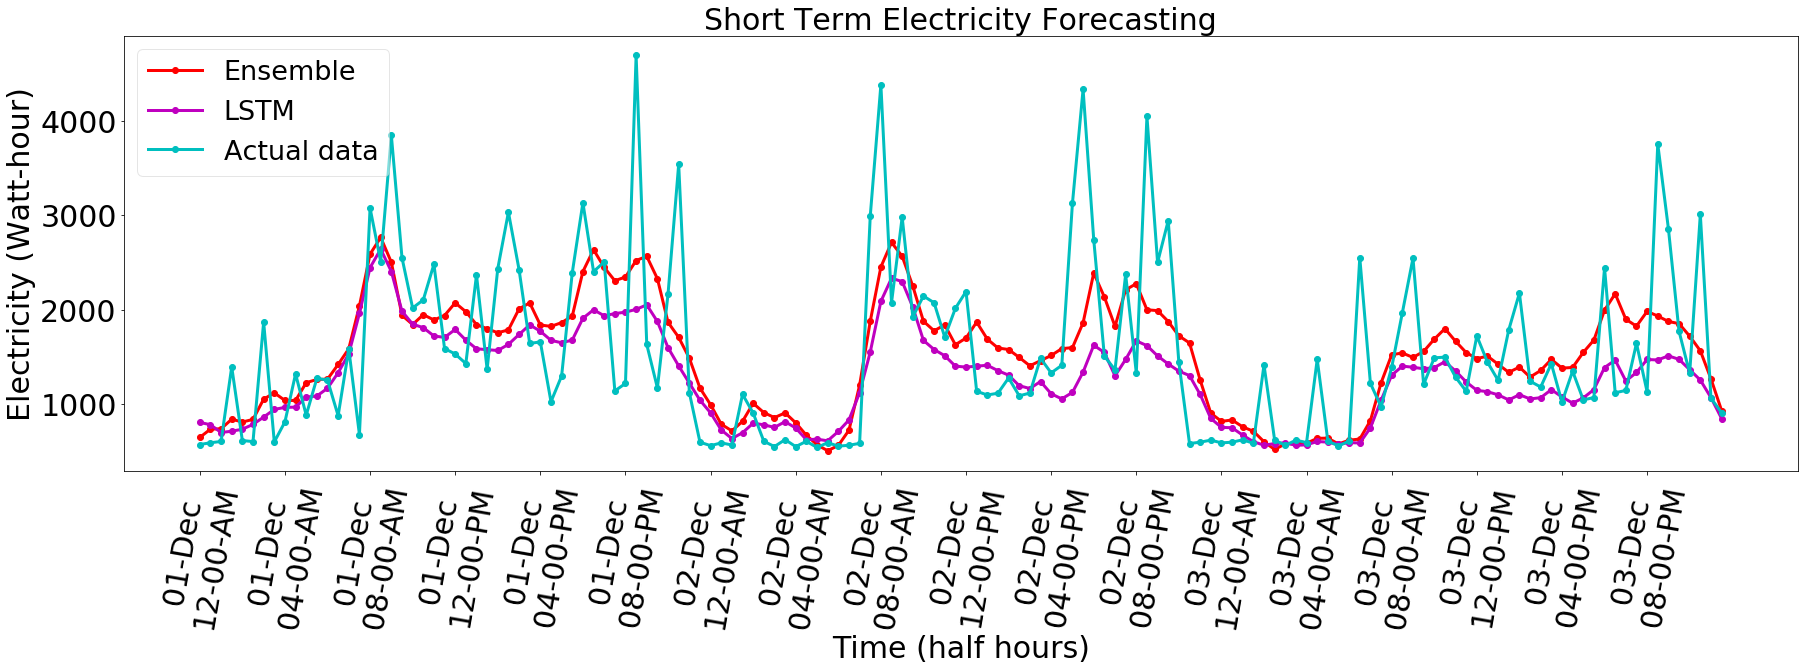

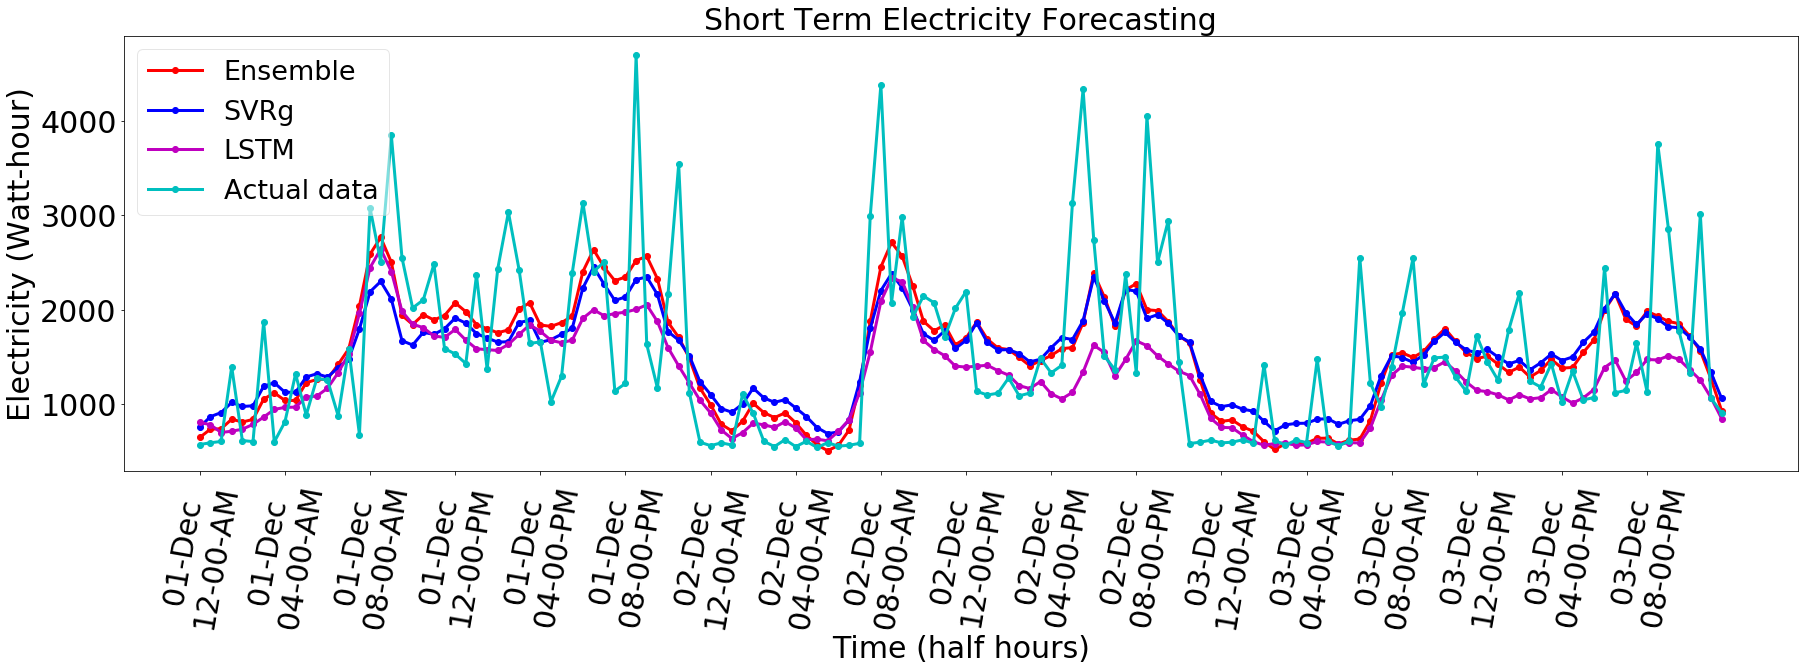

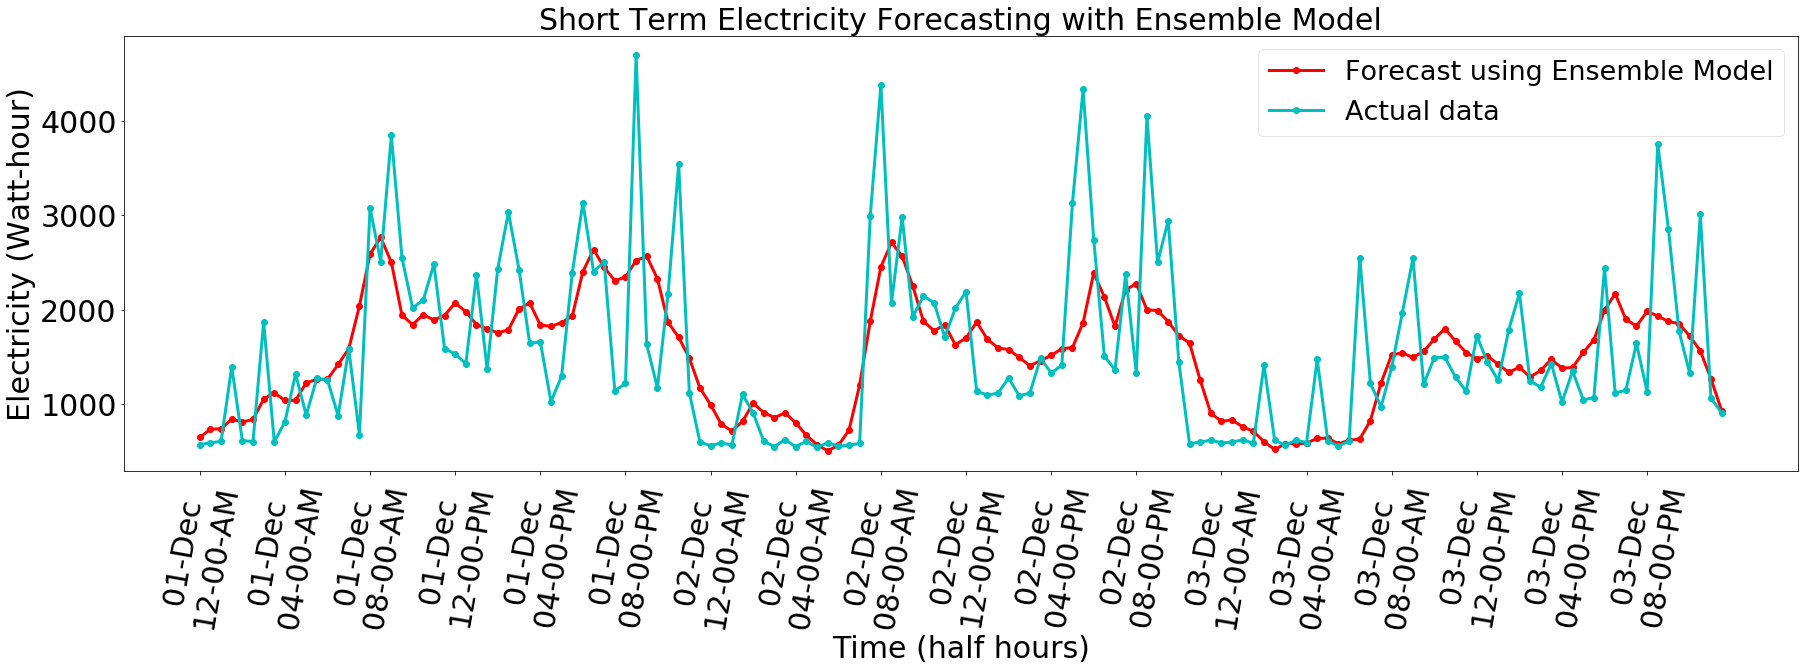

In [0]:
#################################           LR AND LSTM          ##################

plt.figure(figsize=(30,8))

plt.plot(np.roll(test_ens_X[:,1], -0),'mo-',label='LSTM', linewidth=3)
plt.plot(np.roll(test_ens_X[:,0], -0),'bo-',label='SVRg', linewidth=3)

# plt.plot(np.roll(df_Ensemble.values[:,-1], -0),'c-',label='SVRg', linewidth=3)
plt.plot(df_copy_before_smoothing.Apt2['2015-12-01':].values[0:print_till],'co-', label='Actual data', linewidth=3)

plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)


x=np.arange(0,len(test_y1_un_scaled[0:print_till]),8) #take every y_th element
y=reframed_selected_for_opt[alpha:alpha+print_till].index.strftime('%d-%b\n%I-%M-%p')[::8] #double colon prints every y_th element from the list / array
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=0,ymax=x_max)
plt.title("Short Term Electricity Forecasting", fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)

# plt.savefig('Forecast_SVRg vs LSTM.pdf', bbox_inches='tight')



#################################           LR AND ENSEMBLE          ##################

plt.figure(figsize=(30,8))

plt.plot(np.roll(predicted_from_ensemble, -0),'ro-',label='Ensemble', linewidth=3)
plt.plot(np.roll(test_ens_X[:,0], -0),'bo-',label='SVRg', linewidth=3)

# plt.plot(np.roll(df_Ensemble.values[:,-1], -0),'c-',label='SVRg', linewidth=3)
plt.plot(df_copy_before_smoothing.Apt2['2015-12-01':].values[0:print_till],'co-', label='Actual data', linewidth=3)

plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)


x=np.arange(0,len(test_y1_un_scaled[0:print_till]),8) #take every y_th element
y=reframed_selected_for_opt[alpha:alpha+print_till].index.strftime('%d-%b\n%I-%M-%p')[::8] #double colon prints every y_th element from the list / array
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=0,ymax=x_max)
plt.title("Short Term Electricity Forecasting", fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)

# plt.savefig('Forecast_SVRg vs Ensemble.pdf', bbox_inches='tight')


#################################           LSTM  AND ENSEMBLE          ##################

plt.figure(figsize=(30,8))

plt.plot(np.roll(predicted_from_ensemble, -0),'ro-',label='Ensemble', linewidth=3)
plt.plot(np.roll(test_ens_X[:,1], -0),'mo-',label='LSTM', linewidth=3)

# plt.plot(np.roll(df_Ensemble.values[:,-1], -0),'c-',label='SVRg', linewidth=3)
plt.plot(df_copy_before_smoothing.Apt2['2015-12-01':].values[0:print_till],'co-', label='Actual data', linewidth=3)

plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)


x=np.arange(0,len(test_y1_un_scaled[0:print_till]),8) #take every y_th element
y=reframed_selected_for_opt[alpha:alpha+print_till].index.strftime('%d-%b\n%I-%M-%p')[::8] #double colon prints every y_th element from the list / array
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=0,ymax=x_max)
plt.title("Short Term Electricity Forecasting", fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)

# plt.savefig('Forecast_LSTM vs Ensemble.pdf', bbox_inches='tight')



#################################           LR, LSTM AND ENSEMBLE          ##################





plt.figure(figsize=(30,8))

plt.plot(np.roll(predicted_from_ensemble, -0),'ro-',label='Ensemble', linewidth=3)
plt.plot(np.roll(test_ens_X[:,0], -0),'bo-',label='SVRg', linewidth=3)
plt.plot(np.roll(test_ens_X[:,1], -0),'mo-',label='LSTM', linewidth=3)

# plt.plot(np.roll(df_Ensemble.values[:,-1], -0),'c-',label='', linewidth=3)
plt.plot(df_copy_before_smoothing.Apt2['2015-12-01':].values[0:print_till],'co-', label='Actual data', linewidth=3)

plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)


x=np.arange(0,len(test_y1_un_scaled[0:print_till]),8) #take every y_th element
y=reframed_selected_for_opt[alpha:alpha+print_till].index.strftime('%d-%b\n%I-%M-%p')[::8] #double colon prints every y_th element from the list / array
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=0,ymax=x_max)
plt.title("Short Term Electricity Forecasting", fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)

# plt.savefig('Forecast_Ensemble vs LSTM vs SVRg.pdf', bbox_inches='tight')



#################################           ONLY ENSEMBLE          ##################





plt.figure(figsize=(30,8))

plt.plot(np.roll(predicted_from_ensemble, -0),'ro-',label='Forecast using Ensemble Model', linewidth=3)

# plt.plot(np.roll(df_Ensemble.values[:,-1], -0),'c-',label='', linewidth=3)
plt.plot(df_copy_before_smoothing.Apt2['2015-12-01':].values[0:print_till],'co-', label='Actual data', linewidth=3)

plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)


x=np.arange(0,len(test_y1_un_scaled[0:print_till]),8) #take every y_th element
y=reframed_selected_for_opt[alpha:alpha+print_till].index.strftime('%d-%b\n%I-%M-%p')[::8] #double colon prints every y_th element from the list / array
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=0,ymax=x_max)
plt.title("Short Term Electricity Forecasting with Ensemble Model", fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)

# plt.savefig('Forecast_Ensemble.pdf', bbox_inches='tight')


In [0]:
#######################               ERRORS            #############################

Text(0.5,1,'Error vs Length of forecast-LSTM')

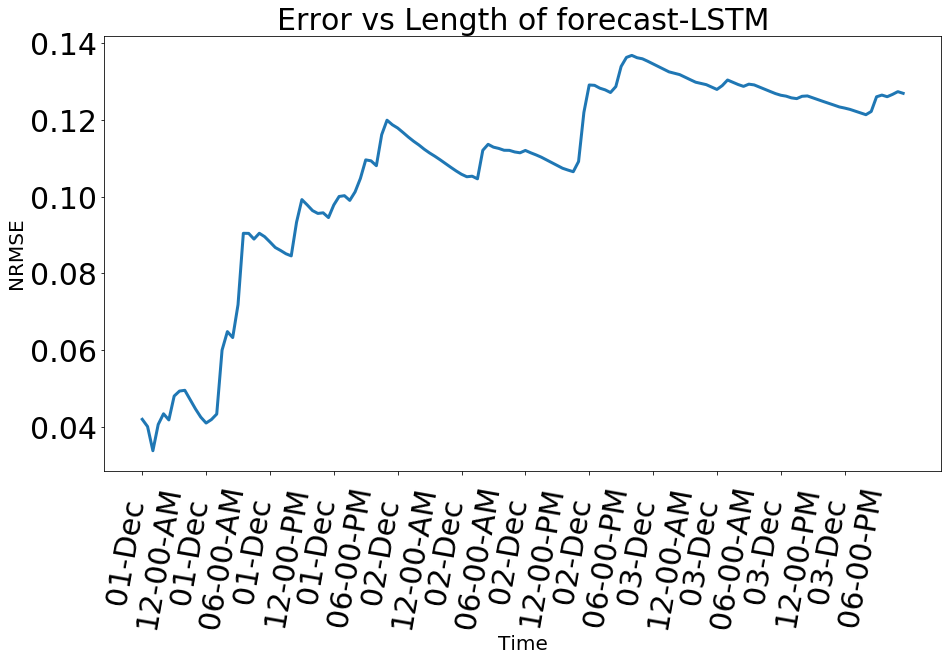

In [0]:
# Error vs Length of forecast ------ LSTM

rmse_propagate_LSTM=[];
mae_propagate_LSTM=[];
r2_propagate_LSTM=[];
for e in range(1,len(pred_list[0:print_till])+1):
    rmse1=np.sqrt(mean_squared_error(test_y1_un_scaled[0:e], np.roll(pred_list_un_scaled[0:e], 0)))
    rmse_propagate_LSTM.append(((rmse1-x_min)/(x_max-x_min)))
    
    mae1=mean_absolute_error(test_y1_un_scaled[0:e], np.roll(pred_list_un_scaled[0:e], 0))
    mae_propagate_LSTM.append(((mae1-x_min)/(x_max-x_min)))
    
    r2=r2_score(test_y1_un_scaled[0:e], np.roll(pred_list_un_scaled[0:e], 0))
    r2_propagate_LSTM.append(r2)
    
plt.figure(figsize=(15,8))    
plt.plot(rmse_propagate_LSTM, linewidth=3)

plt.ylabel('NRMSE', fontsize=20)
plt.xlabel('Time', fontsize=20)

x=np.arange(0,len(rmse_propagate_LSTM),12) #take every y_th element
y=reframed_selected_for_opt[alpha:alpha+print_till].index.strftime('%d-%b\n%I-%M-%p')[::12] #double colon prints every y_th element from the list / array
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

# plt.ylim(0, 0.13)
plt.title('Error vs Length of forecast-LSTM', fontsize=30)
#plt.savefig('Error.pdf', bbox_inches='tight')


Text(0.5,1,'Error vs Length of forecast-SVRg')

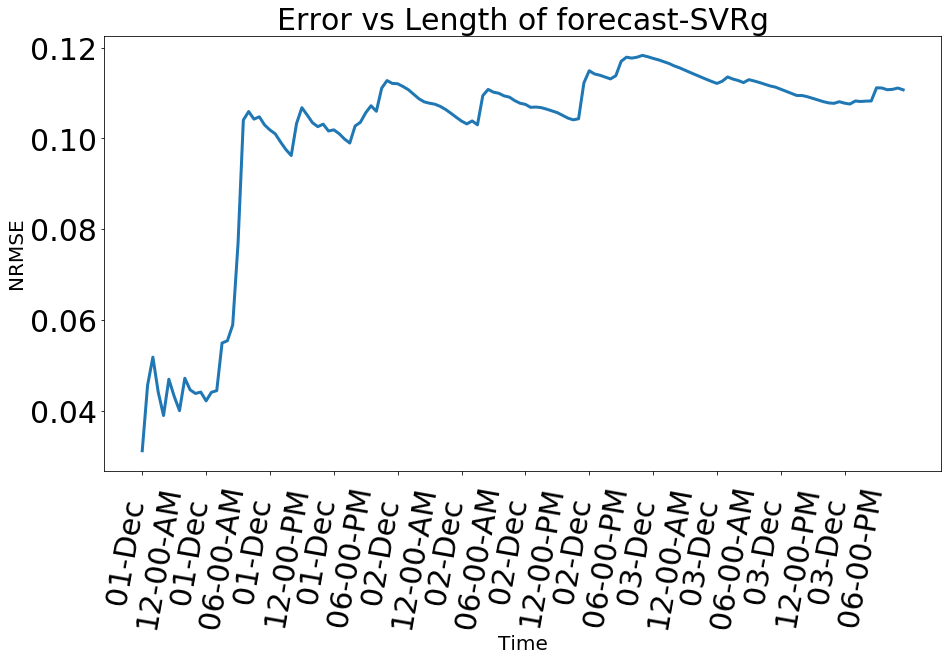

In [0]:
# Error vs Length of forecast ------ SVRg

rmse_propagate_LR=[];
mae_propagate_LR=[];
r2_propagate_LR=[];

for e in range(1,len(pred_list[0:print_till])+1):
    rmse1=np.sqrt(mean_squared_error(test_y1_un_scaled[0:e], np.roll(pred_list_un_scaled_LR[0:e], 0)))
    rmse_propagate_LR.append(((rmse1-x_min)/(x_max-x_min)))
    
    mae1=mean_absolute_error(test_y1_un_scaled[0:e], np.roll(pred_list_un_scaled_LR[0:e], 0))
    mae_propagate_LR.append(((mae1-x_min)/(x_max-x_min)))
    
    r2=r2_score(test_y1_un_scaled[0:e], np.roll(pred_list_un_scaled_LR[0:e], 0))
    r2_propagate_LR.append(r2)
    
plt.figure(figsize=(15,8))    
plt.plot(rmse_propagate_LR, linewidth=3)

plt.ylabel('NRMSE', fontsize=20)
plt.xlabel('Time', fontsize=20)

x=np.arange(0,len(rmse_propagate_LR),12) #take every y_th element
y=reframed_selected_for_opt[alpha:alpha+print_till].index.strftime('%d-%b\n%I-%M-%p')[::12] #double colon prints every y_th element from the list / array
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

# plt.ylim(0, 0.13)
plt.title('Error vs Length of forecast-SVRg', fontsize=30)
#plt.savefig('Error.pdf', bbox_inches='tight')


Text(0.5,1,'Error vs Length of forecast-Ensemble')

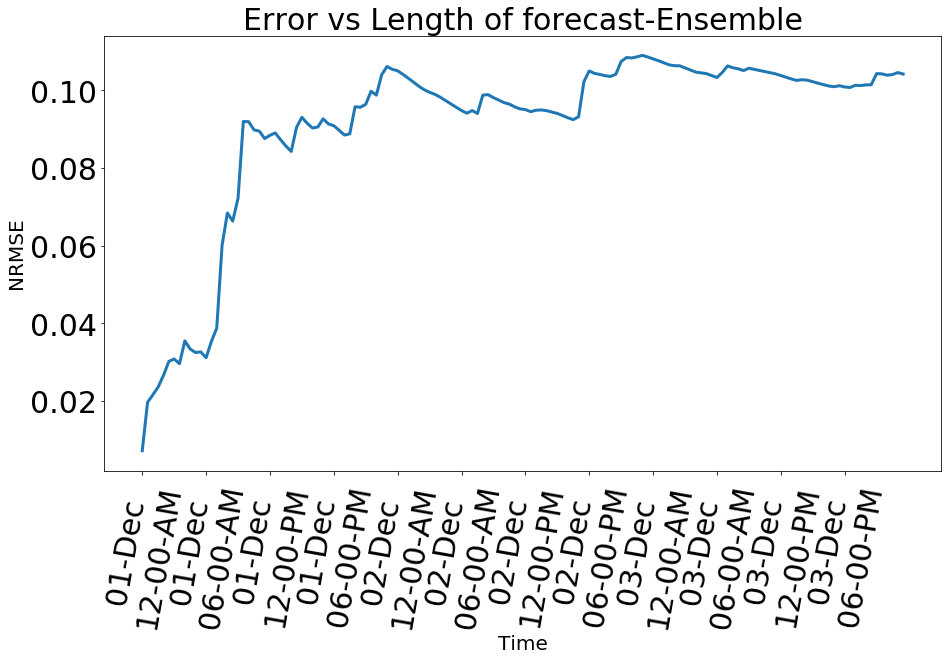

In [0]:
# Error vs Length of forecast ------ Ensemble

rmse_propagate_Ens=[];
mae_propagate_Ens=[];
r2_propagate_Ens=[];
for e in range(1,len(pred_list[0:print_till])+1):
    rmse1=np.sqrt(mean_squared_error(test_y1_un_scaled[0:e], np.roll(predicted_from_ensemble[0:e], 0)))
    rmse_propagate_Ens.append(((rmse1-x_min)/(x_max-x_min)))
    
    mae1=mean_absolute_error(test_y1_un_scaled[0:e], np.roll(predicted_from_ensemble[0:e], 0))
    mae_propagate_Ens.append(((mae1-x_min)/(x_max-x_min)))
    
    r2=r2_score(test_y1_un_scaled[0:e], np.roll(predicted_from_ensemble[0:e], 0))
    r2_propagate_Ens.append(r2)
    
plt.figure(figsize=(15,8))    
plt.plot(rmse_propagate_Ens, linewidth=3)

plt.ylabel('NRMSE', fontsize=20)
plt.xlabel('Time', fontsize=20)

x=np.arange(0,len(rmse_propagate_LSTM),12) #take every y_th element
y=reframed_selected_for_opt[alpha:alpha+print_till].index.strftime('%d-%b\n%I-%M-%p')[::12] #double colon prints every y_th element from the list / array
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

# plt.ylim(0, 0.13)
plt.title('Error vs Length of forecast-Ensemble', fontsize=30)
#plt.savefig('Error.pdf', bbox_inches='tight')


In [0]:
#######################               OPTIMIZATION            #############################

In [0]:
df_new = pd.DataFrame()
df_new['time']=reframed_selected_for_opt.index[alpha+split:alpha+print_till]
# df_new['actual_test']=test_y1_un_scaled[split:print_till]
df_new['actual_test']=df_copy_before_smoothing.Apt2['2015-12-01':].values[split:print_till]
df_new['predicted_test']=predicted_from_ensemble[split:print_till]
df_new=df_new.set_index('time')
df_new['Hour'] = df_new.index.hour.astype(int)

on_peak=17.5
mid_peak=12.8
off_peak=8.3
df_new.loc[df_new.eval('Hour>=7 and Hour<11'), 'Price']=on_peak
df_new.loc[df_new.eval('Hour>=11 and Hour<17'), 'Price']=mid_peak
df_new.loc[df_new.eval('Hour>=17 and Hour<19'), 'Price']=on_peak
df_new.loc[df_new.eval('Hour>=19 and Hour<24'), 'Price']=off_peak
df_new.loc[df_new.eval('Hour>=0 and Hour<7'), 'Price']=off_peak

df_new.head()

,actual_test,predicted_test,Hour,Price
time,,,,
2015-12-02 00:00:00,562.646112,994.863768,0,8.3
2015-12-02 00:30:00,592.002778,789.613750,0,8.3
2015-12-02 01:00:00,569.595000,718.272647,1,8.3
2015-12-02 01:30:00,1105.252222,820.121215,1,8.3
2015-12-02 02:00:00,907.157778,1010.342121,2,8.3



 Status: Optimal

 Actual Energy (watt-hour):  140257.20638649998

 Optimized Energy (watt-hour):  133244.34587

 Energy Saved (watt-our):  7012.86051649999

 Actual Cost: $ 1.7665519733325508

 Optimized Cost: $ 1.5382187599129997

 Cost Saving (%):  12.925360638487573

 Energy Saving (%):  5.0000001405810055


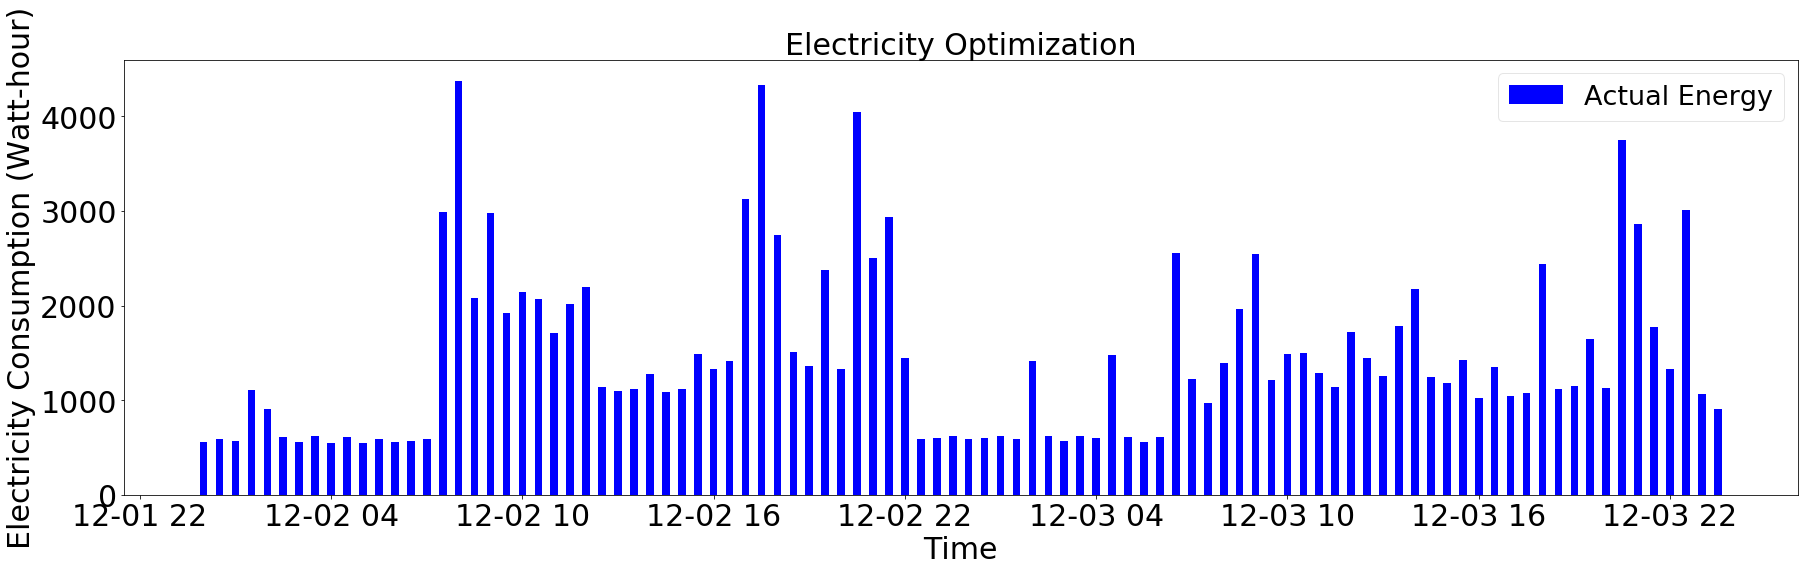

No handles with labels found to put in legend.


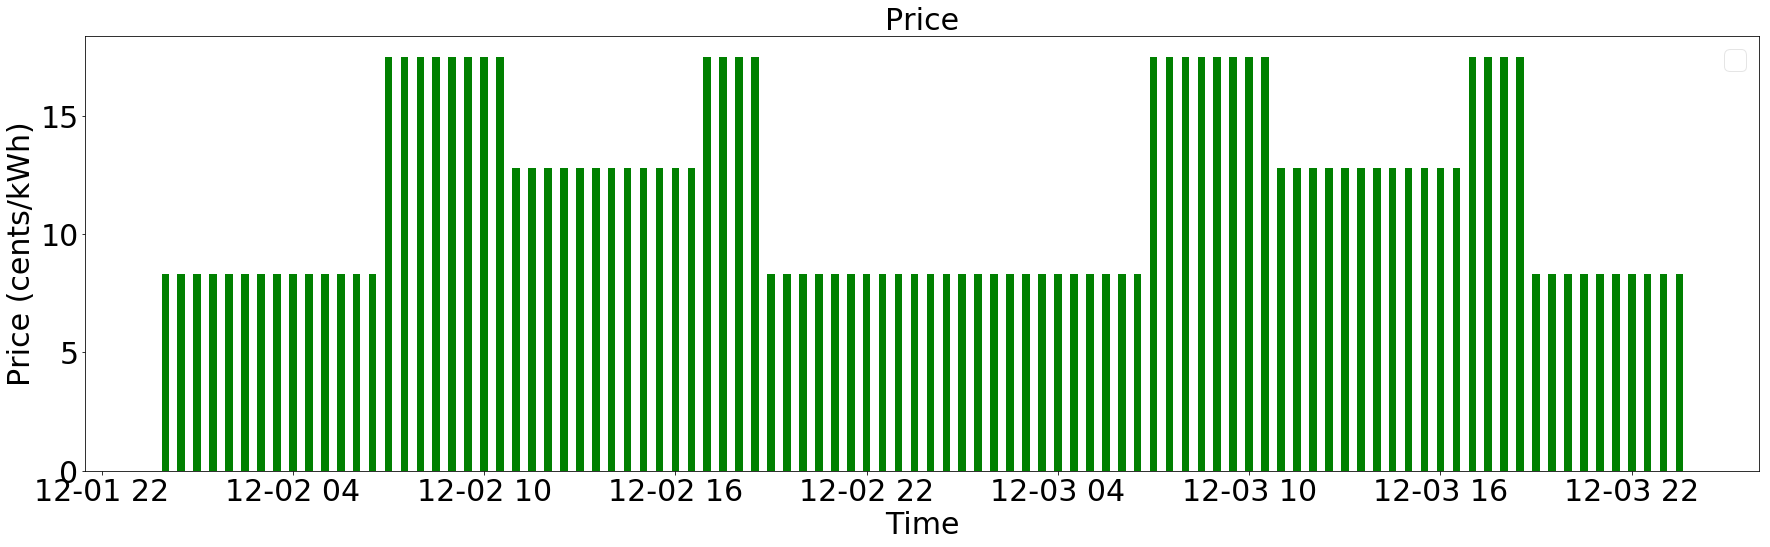

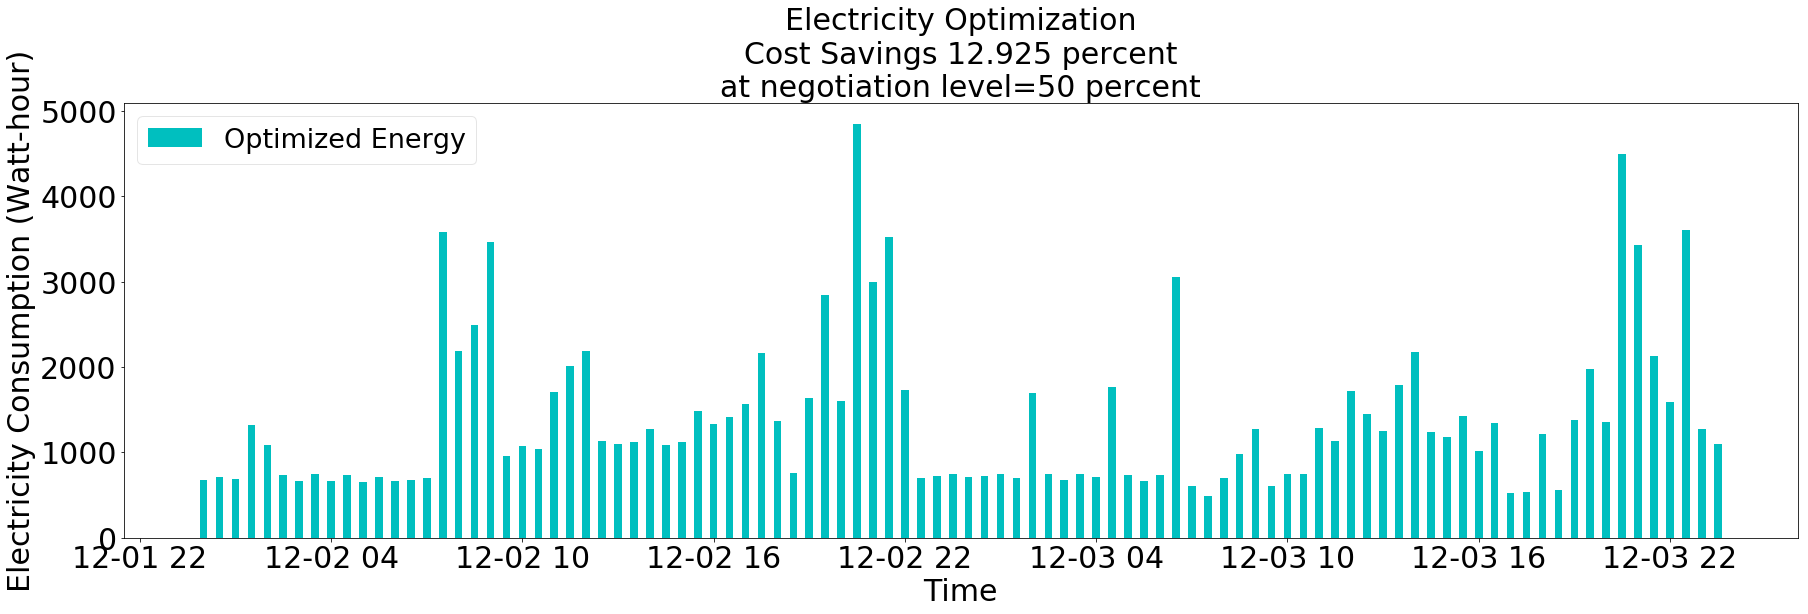

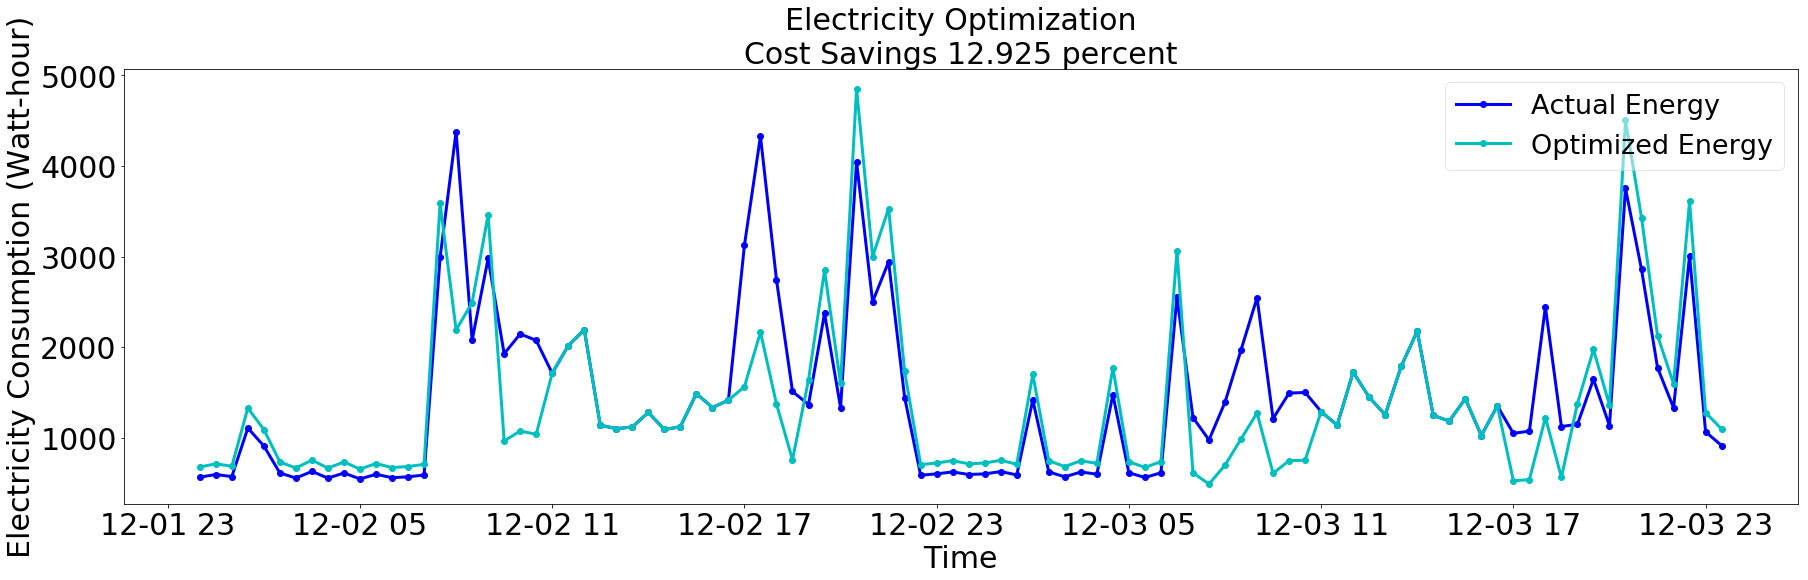

No handles with labels found to put in legend.


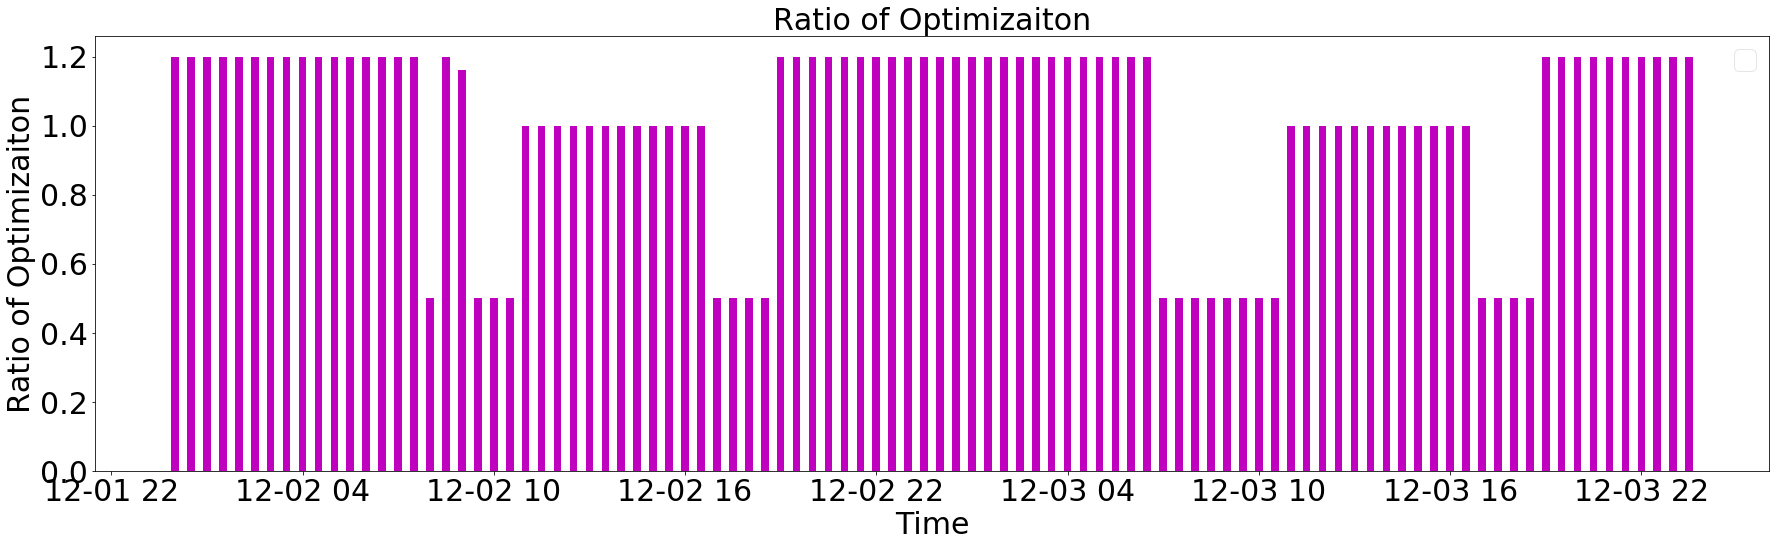

In [0]:
####################################################    OPTIMIZATION   WITH ACTUAL DATA   ################################
df_new1=df_new.copy()
eOld=df_new1.actual_test
n=0.5

#Initiate LP solver
model_opt = pulp.LpProblem("Bill Minimizing Problem", pulp.LpMinimize)

#Create variables dict
eNew = pulp.LpVariable.dicts("eNew",range(len(df_new1)),lowBound=0)

#obj function
model_opt += pulp.lpSum([eNew[i] * df_new.Price[i] for i in range(len(df_new1))])

#Constraints

#each new value should be less than 1.2*eOld and greater than  (1-n)*eOld
for i in range(len(df_new1)):
        model_opt += eNew[i] >= (1-n)*eOld[i]
        model_opt += eNew[i] <= (1.2)*eOld[i]

        
# for on-peak hours, eNew can decrease upto (1-n)*eOld
# for off-peak hours, eNew can increase upto (1+n)*eOld
# for mid-peak hours, eNew is same as eOld
#so we are actually decreasing the load in peak hours and sending it to off-peak hours

for i in range(len(df_new1)):
    if (df_new1.Price[i]==on_peak):
        model_opt += eNew[i] >= (1-n)*eOld[i]  #on-peak
    elif (df_new1.Price[i]==off_peak):
#         model_opt += eNew[i] <= (1+n)*eOld[i]  #off-peak
        model_opt += eNew[i] >= (1)*eOld[i]
    elif (df_new1.Price[i]==mid_peak):
        model_opt += eNew[i] == eOld[i]
        
#New total energy should be same as old energy (it can be shifted from on-peak to off-peak hours but toal has to be same)
sum_eNew=0
for i in range(len(df_new1)):
    sum_eNew += eNew[i]    
model_opt += sum_eNew >= 0.95*df_new1.actual_test.sum()

#Solve it
model_opt.solve();

#status of optimized problem
print ("\n Status: " + LpStatus[model_opt.status])

#add new column in df_new1 for optimized values
optimized=[]
for l in range(len(df_new1)):
    optimized.append(eNew[l].varValue)
df_new1['Optimized']=optimized
df_new1.head()

########################################## OPTIMIZATION DONE  --- NOW RESULTS     #################################################

#Display output
sum_actualCost=0
sum_OptCost=0
for i in range(len(df_new1)):
    sum_actualCost += df_new1.actual_test[i]*df_new1.Price[i]
    sum_OptCost += df_new1.Optimized[i]*df_new1.Price[i]
print ("\n Actual Energy (watt-hour): " , df_new1.actual_test.sum())
print ("\n Optimized Energy (watt-hour): " , df_new1.Optimized.sum())
print ("\n Energy Saved (watt-our): " , df_new1.actual_test.sum()-df_new1.Optimized.sum())
print ("\n Actual Cost: $" ,0.000001*sum_actualCost)
print ("\n Optimized Cost: $" ,0.000001*sum_OptCost)
print ("\n Cost Saving (%): " , 100*(sum_actualCost-sum_OptCost)/sum_actualCost)
print ("\n Energy Saving (%): " , 100*(df_new1.actual_test.sum()-df_new1.Optimized.sum())/df_new1.actual_test.sum())


plt.figure(figsize=(30,8))


########################################## ACTUAL BAR PLOT     #################################################

plt.bar(df_new1.index, df_new1['actual_test'], color='b', label='Actual Energy', width=0.01)
# plt.bar(df_new1.index, df_new1['predicted_test'], color='b', label='Predicted Test data', width=0.01)

plt.ylabel('Electricity Consumption (Watt-hour)', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=x_min,ymax=x_max)
plt.title("Electricity Optimization", fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)
# plt.savefig('Opt_Actual.pdf', bbox_inches='tight')
plt.show()

########################################## PRICE BAR PLOT     #################################################

plt.figure(figsize=(30,8))

plt.bar(df_new1.index,df_new1['Price'], color='g', width=0.01)

plt.ylabel('Price (cents/kWh)', fontsize=30)
plt.xlabel('Time', fontsize=30)

plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=x_min,ymax=x_max)
plt.title("Price", fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)
# plt.savefig('Opt_price.pdf', bbox_inches='tight')
plt.show()

########################################## OPTIMIXED BAR PLOT     #################################################

plt.figure(figsize=(30,8))

plt.bar(df_new1.index, df_new1['Optimized'], color='c', label='Optimized Energy', width=0.01)

plt.ylabel('Electricity Consumption (Watt-hour)', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=x_min,ymax=x_max)
plt.title("Electricity Optimization\nCost Savings %0.3f percent\nat negotiation level=%i percent" % ((100*(sum_actualCost-sum_OptCost)/sum_actualCost), n*100), fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)
# plt.savefig('Opt_Optimized from Actual.pdf', bbox_inches='tight')
plt.show()

########################################## LINE PLOTS COMBINED     #################################################

plt.figure(figsize=(30,8))

plt.plot(df_new1['actual_test'], 'bo-', label='Actual Energy', linewidth=3)
# plt.plot(df_new1['predicted_test'], 'bo-', label='Predicted Test data', linewidth=3)
plt.plot(df_new1['Optimized'], 'co-', label='Optimized Energy', linewidth=3)
# plt.plot(df_new1.index[3:], np.roll(pd.DataFrame(data=optimized).rolling(4).mean().dropna().iloc[:,0], -3), 'ro-', label='Optimized Test data', linewidth=3)

plt.ylabel('Electricity Consumption (Watt-hour)', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=x_min,ymax=x_max)
plt.title("Electricity Optimization\nCost Savings %0.3f percent" % (100*(sum_actualCost-sum_OptCost)/sum_actualCost), fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)
#plt.savefig('5a.pdf', bbox_inches='tight')
plt.show()




######################################        Ratio graph           ####################################

plt.figure(figsize=(30,8))

plt.bar(df_new1.index, optimized/eOld, color='m', width=0.01)

plt.ylabel('Ratio of Optimizaiton', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=x_min,ymax=x_max)
plt.title("Ratio of Optimizaiton", fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)
#plt.savefig('5a.pdf', bbox_inches='tight')
plt.show()


In [0]:
df_new['optimizedEnergy_using_actual']=df_new1.Optimized
df_new['optRatio_using_actual']=df_new1.Optimized/eOld


 Status: Optimal

 Predicted Energy (watt-hour):  134919.87808041967

 Optimized Energy (watt-hour):  128173.88396

 Energy Saved (watt-our):  6745.994120419666

 Predicted Cost: $ 1.6870992183392495

 Optimized Cost: $ 1.4686679732799994

 Cost Saving (%):  12.947148732264234

 Energy Saving (%):  4.809730846791613


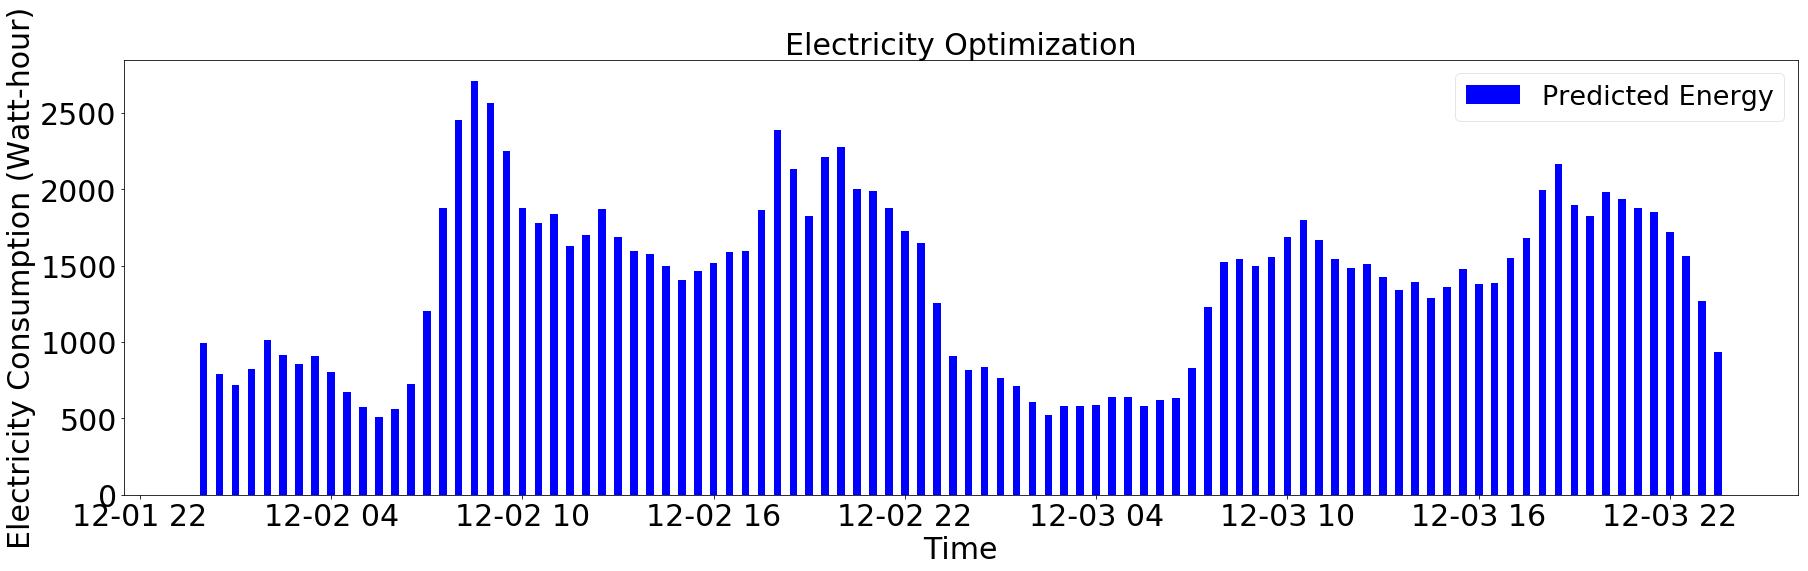

No handles with labels found to put in legend.


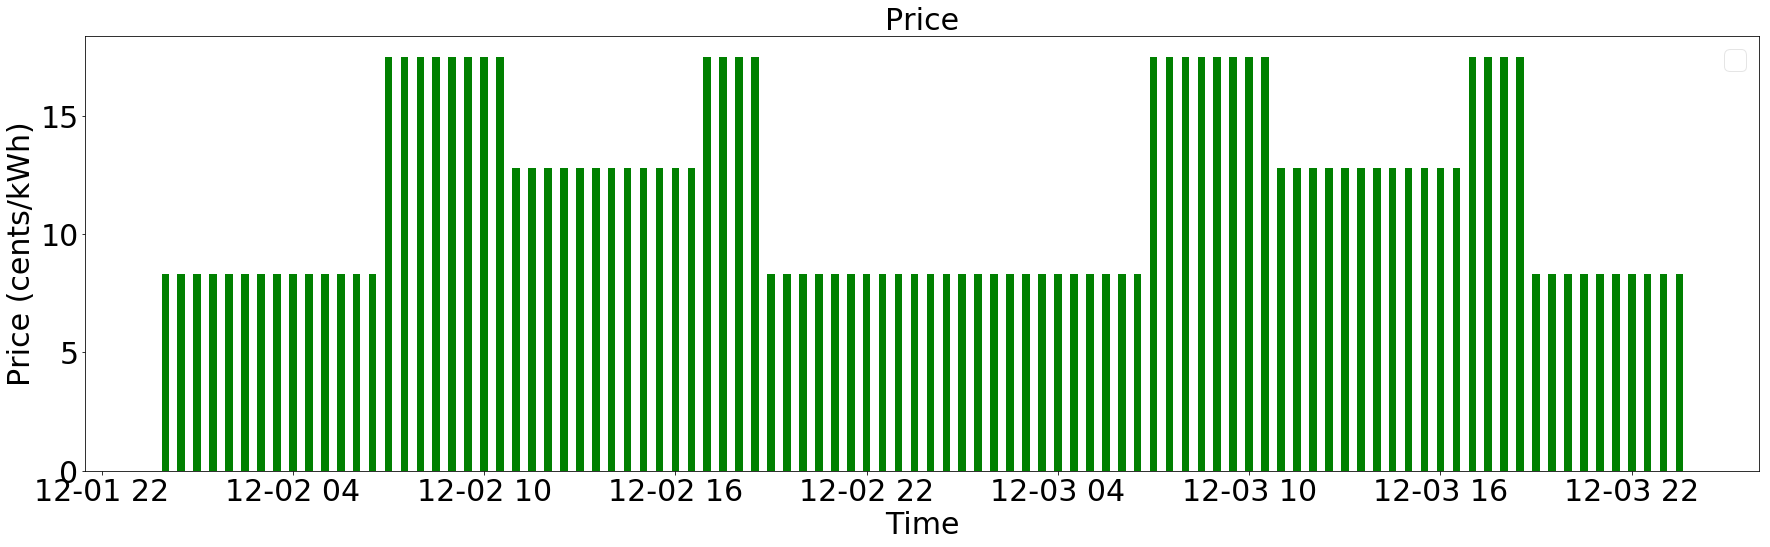

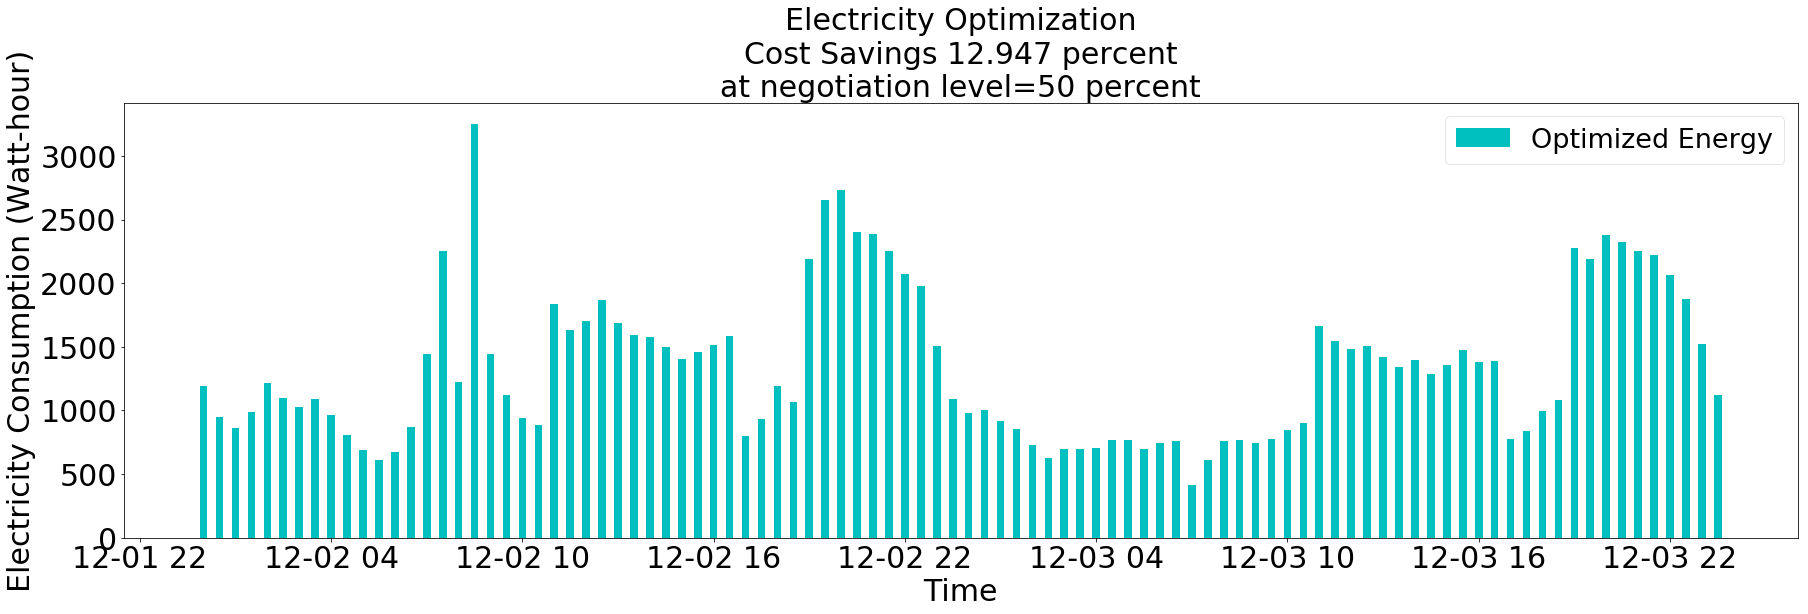

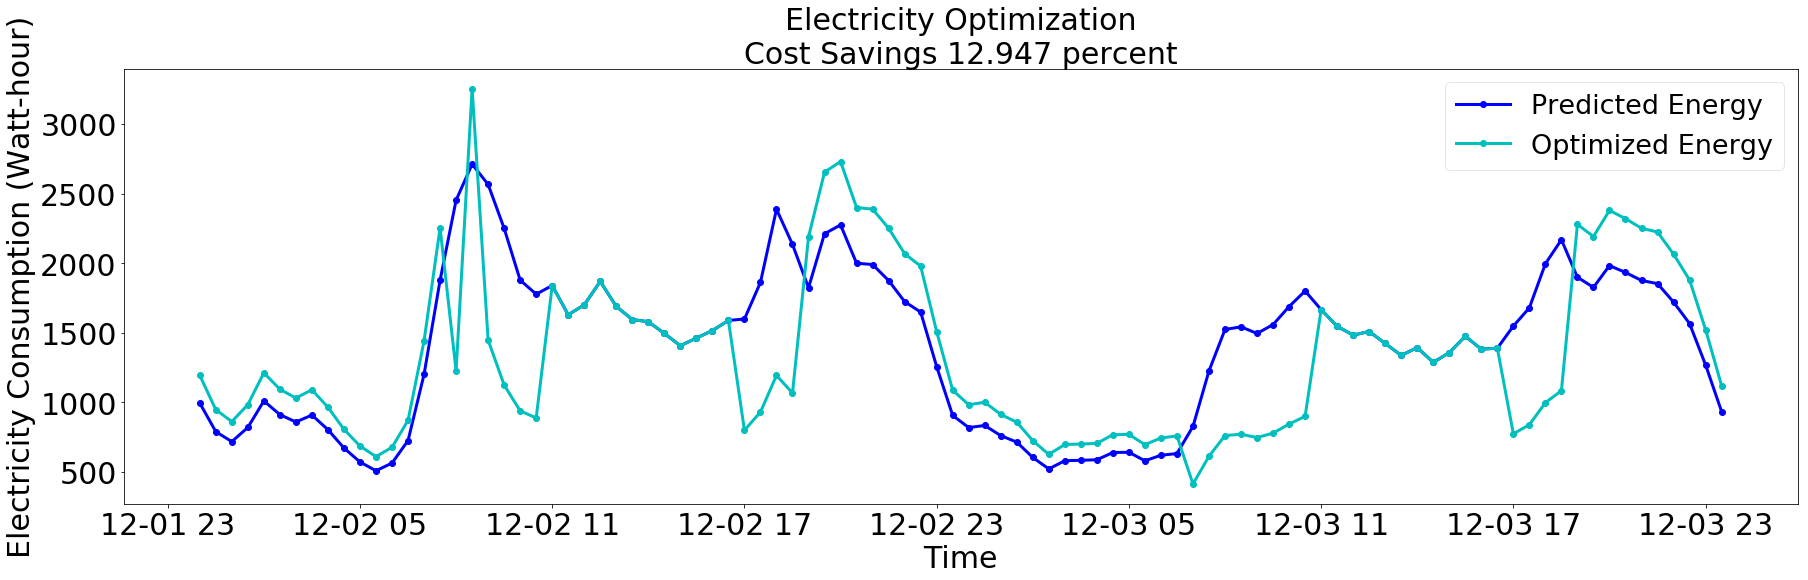

No handles with labels found to put in legend.


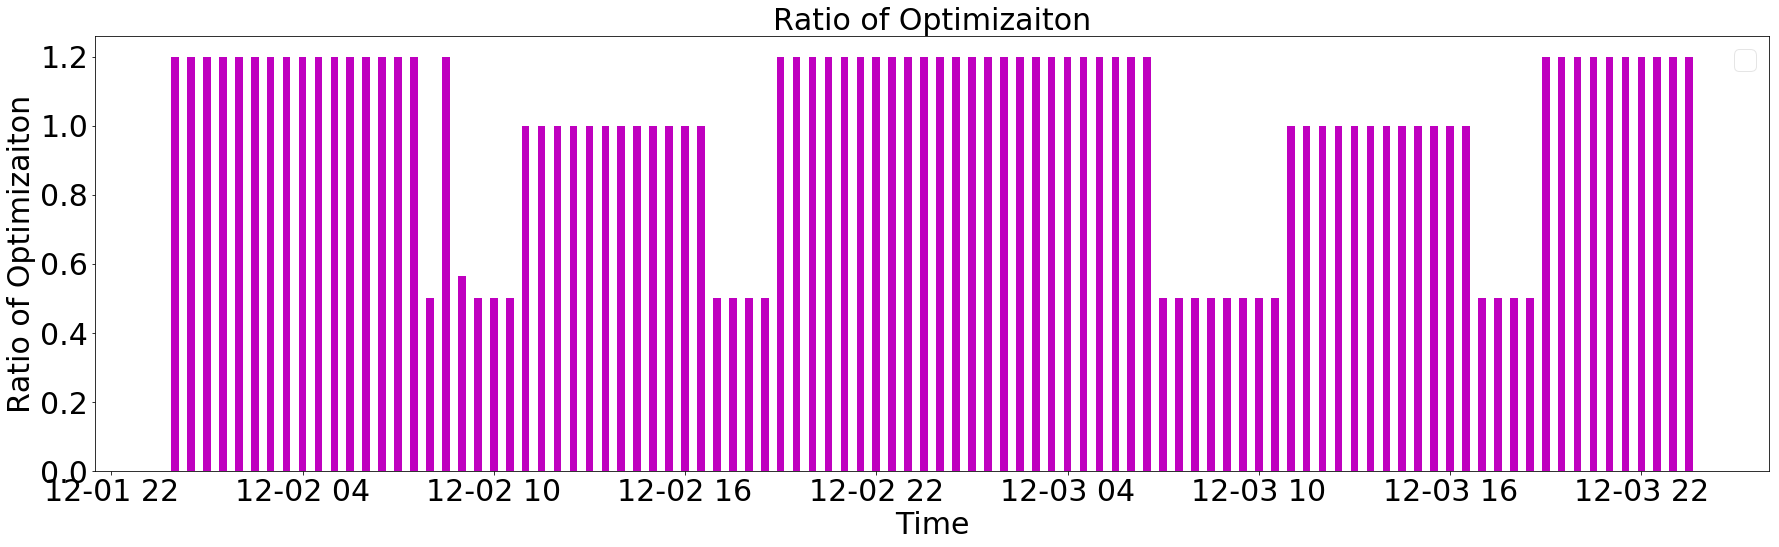

In [0]:
####################################################    OPTIMIZATION   WITH PREDICTED DATA   ################################
df_new1=df_new.copy()
eOld=df_new1.predicted_test
n=0.5

#Initiate LP solver
model_opt = pulp.LpProblem("Bill Minimizing Problem", pulp.LpMinimize)

#Create variables dict
eNew = pulp.LpVariable.dicts("eNew",range(len(df_new1)),lowBound=0)

#obj function
model_opt += pulp.lpSum([eNew[i] * df_new.Price[i] for i in range(len(df_new1))])

#Constraints

#each new value should be less than 1.2*eOld and greater than  (1-n)*eOld
for i in range(len(df_new1)):
        model_opt += eNew[i] >= (1-n)*eOld[i]
        model_opt += eNew[i] <= (1.2)*eOld[i]

        
# for on-peak hours, eNew can decrease upto (1-n)*eOld
# for off-peak hours, eNew can increase upto (1+n)*eOld
# for mid-peak hours, eNew is same as eOld
#so we are actually decreasing the load in peak hours and sending it to off-peak hours

for i in range(len(df_new1)):
    if (df_new1.Price[i]==on_peak):
        model_opt += eNew[i] >= (1-n)*eOld[i]  #on-peak
    elif (df_new1.Price[i]==off_peak):
#         model_opt += eNew[i] <= (1+n)*eOld[i]  #off-peak
        model_opt += eNew[i] >= (1)*eOld[i]
    elif (df_new1.Price[i]==mid_peak):
        model_opt += eNew[i] == eOld[i]
        
#New total energy should be same as old energy (it can be shifted from on-peak to off-peak hours but toal has to be same)
sum_eNew=0
for i in range(len(df_new1)):
    sum_eNew += eNew[i]    
model_opt += sum_eNew >= 0.95*df_new1.predicted_test.sum()

#Solve it
model_opt.solve();

#status of optimized problem
print ("\n Status: " + LpStatus[model_opt.status])

#add new column in df_new1 for optimized values
optimized=[]
for l in range(len(df_new1)):
    optimized.append(eNew[l].varValue)
df_new1['Optimized']=optimized
df_new1.head()

########################################## OPTIMIZATION DONE  --- NOW RESULTS     #################################################

#Display output
sum_actualCost=0
sum_OptCost=0
for i in range(len(df_new1)):
    sum_actualCost += df_new1.predicted_test[i]*df_new1.Price[i]
    sum_OptCost += df_new1.Optimized[i]*df_new1.Price[i]
print ("\n Predicted Energy (watt-hour): " , df_new1.predicted_test.sum())
print ("\n Optimized Energy (watt-hour): " , df_new1.Optimized.sum())
print ("\n Energy Saved (watt-our): " , df_new1.predicted_test.sum()-df_new1.Optimized.sum())
print ("\n Predicted Cost: $" ,0.000001*sum_actualCost)
print ("\n Optimized Cost: $" ,0.000001*sum_OptCost)
print ("\n Cost Saving (%): " , 100*(sum_actualCost-sum_OptCost)/sum_actualCost)
print ("\n Energy Saving (%): " , 100*(df_new1.predicted_test.sum()-df_new1.Optimized.sum())/df_new1.actual_test.sum())


plt.figure(figsize=(30,8))


########################################## PREDICTED BAR PLOT     #################################################

plt.bar(df_new1.index, df_new1['predicted_test'], color='b', label='Predicted Energy', width=0.01)
# plt.bar(df_new1.index, df_new1['predicted_test'], color='b', label='Predicted Test data', width=0.01)

plt.ylabel('Electricity Consumption (Watt-hour)', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=x_min,ymax=x_max)
plt.title("Electricity Optimization", fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)
# plt.savefig('Opt_Predicted.pdf', bbox_inches='tight')
plt.show()


########################################## PRICE BAR PLOT     #################################################

plt.figure(figsize=(30,8))

plt.bar(df_new1.index,df_new1['Price'], color='g', width=0.01)

plt.ylabel('Price (cents/kWh)', fontsize=30)
plt.xlabel('Time', fontsize=30)

plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=x_min,ymax=x_max)
plt.title("Price", fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)
#plt.savefig('5a.pdf', bbox_inches='tight')
plt.show()


########################################## OPTIMIXED BAR PLOT     #################################################

plt.figure(figsize=(30,8))

plt.bar(df_new1.index, df_new1['Optimized'], color='c', label='Optimized Energy', width=0.01)

plt.ylabel('Electricity Consumption (Watt-hour)', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=x_min,ymax=x_max)
plt.title("Electricity Optimization\nCost Savings %0.3f percent\nat negotiation level=%i percent" % ((100*(sum_actualCost-sum_OptCost)/sum_actualCost), n*100), fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)
# plt.savefig('Opt_Optimized from Predicted.pdf', bbox_inches='tight')
plt.show()

########################################## LINE PLOTS COMBINED     #################################################

plt.figure(figsize=(30,8))

plt.plot(df_new1['predicted_test'], 'bo-', label='Predicted Energy', linewidth=3)
# plt.plot(df_new1['predicted_test'], 'bo-', label='Predicted Test data', linewidth=3)
plt.plot(df_new1['Optimized'], 'co-', label='Optimized Energy', linewidth=3)
# plt.plot(df_new1.index[3:], np.roll(pd.DataFrame(data=optimized).rolling(4).mean().dropna().iloc[:,0], -3), 'ro-', label='Optimized Test data', linewidth=3)

plt.ylabel('Electricity Consumption (Watt-hour)', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=x_min,ymax=x_max)
plt.title("Electricity Optimization\nCost Savings %0.3f percent" % (100*(sum_actualCost-sum_OptCost)/sum_actualCost), fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)
#plt.savefig('5a.pdf', bbox_inches='tight')
plt.show()


######################################        Ratio graph           ####################################

plt.figure(figsize=(30,8))

plt.bar(df_new1.index, optimized/eOld, color='m', width=0.01)

plt.ylabel('Ratio of Optimizaiton', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=30)

#plt.ylim(ymin=x_min,ymax=x_max)
plt.title("Ratio of Optimizaiton", fontsize=30)
plt.legend(loc='best', fontsize=27,framealpha=0.5)
#plt.savefig('5a.pdf', bbox_inches='tight')
plt.show()




In [0]:
df_new['optimizedEnergy_using_predicted']=df_new1.Optimized
df_new['optRatio_using_predicted']=df_new1.Optimized/eOld

In [0]:
#############################           SAVE RESULTS            ######################

In [0]:
df_Errors = pd.DataFrame()
df_Errors['time']=reframed_selected_for_opt.index[alpha:alpha+print_till]
df_Errors['SVRg_nrmse']=rmse_propagate_LR
df_Errors['LSTM_nrmse']=rmse_propagate_LSTM
df_Errors['Ens_nrmse']=rmse_propagate_Ens


df_Errors['SVRg_mae']=mae_propagate_LR
df_Errors['LSTM_mae']=mae_propagate_LSTM
df_Errors['Ens_mae']=mae_propagate_Ens

df_Errors['SVRg_r2']=r2_propagate_LR
df_Errors['LSTM_r2']=r2_propagate_LSTM
df_Errors['Ens_r2']=r2_propagate_Ens

df_Errors=df_Errors.set_index('time')

In [0]:
df_Ensemble['actual_test_to_plot']=df_copy_before_smoothing.Apt2['2015-12-01':].values[0:print_till]
df_Ensemble['Ensemble']=predicted_from_ensemble

In [0]:
df_Train = pd.DataFrame()
df_Train['time']=reframed_selected_for_opt.index[:alpha]
df_Train['train_actual']=train_y_un_scaled
df_Train['train_LSTM']=pred_train_x_un_scaled
df_Train['train_SVRg']=pred_train_x_un_scaled_LR

df_Train=df_Train.set_index('time')

In [0]:
df_Train.head()

,train_actual,train_LSTM,train_SVRg
time,,,
2015-07-31 00:30:00,1064.153056,448.542603,610.519250
2015-07-31 01:00:00,1059.101667,558.856812,1141.199715
2015-07-31 01:30:00,623.643611,554.778137,650.909601
2015-07-31 02:00:00,615.781389,430.579224,542.517219
2015-07-31 02:30:00,608.894444,442.144653,517.273250


In [0]:
df_Ensemble.head()

,SVRg,LSTM,actual_test,actual_test_to_plot,Ensemble
time,,,,,
2015-12-01 00:00:00,758.953790,808.210541,590.083055,574.446667,649.342065
2015-12-01 00:30:00,869.261231,784.207892,583.708333,592.970000,737.069229
2015-12-01 01:00:00,912.019293,701.449837,600.043611,607.117222,740.904112
2015-12-01 01:30:00,1020.063482,715.316746,1001.208333,1395.299444,842.183567
2015-12-01 02:00:00,976.852770,736.334051,1005.813889,616.328334,812.588862


In [0]:
df_Errors.head()

,SVRg_nrmse,LSTM_nrmse,Ens_nrmse,SVRg_mae,LSTM_mae,Ens_mae,SVRg_r2,LSTM_r2,Ens_r2
time,,,,,,,,,
2015-12-01 00:00:00,0.031227,0.042020,0.007209,0.031227,0.042020,0.007209,0.000000,0.000000,0.000000
2015-12-01 00:30:00,0.045625,0.040129,0.019698,0.044010,0.040088,0.017519,-5415.618145,-4319.175816,-1329.370793
2015-12-01 01:00:00,0.051835,0.033840,0.021614,0.050201,0.032207,0.020042,-1528.809490,-722.371435,-344.762776
2015-12-01 01:30:00,0.044160,0.040680,0.023655,0.037240,0.038372,0.022299,-0.646558,-0.425065,0.428048
2015-12-01 02:00:00,0.038978,0.043457,0.026651,0.029906,0.041352,0.025152,-0.022109,-0.236915,0.463429


In [0]:
df_new.head()

,actual_test,predicted_test,Hour,Price,optimizedEnergy_using_actual,optRatio_using_actual,optimizedEnergy_using_predicted,optRatio_using_predicted
time,,,,,,,,
2015-12-02 00:00:00,562.646112,994.863768,0,8.3,675.17533,1.2,1193.83650,1.2
2015-12-02 00:30:00,592.002778,789.613750,0,8.3,710.40333,1.2,947.53650,1.2
2015-12-02 01:00:00,569.595000,718.272647,1,8.3,683.51400,1.2,861.92718,1.2
2015-12-02 01:30:00,1105.252222,820.121215,1,8.3,1326.30270,1.2,984.14546,1.2
2015-12-02 02:00:00,907.157778,1010.342121,2,8.3,1088.58930,1.2,1212.41050,1.2


In [0]:
# df_Train.to_csv('df_Train.csv')
# df_Ensemble.to_csv('df_Ensemble.csv')
# df_Errors.to_csv('df_Errors.csv')
# df_new.to_csv('df_Optimization.csv')

In [0]:
#############################           PRINT RESULTS            ######################

In [0]:
#print full ndarray
np.set_printoptions(threshold=np.inf)

In [0]:
df_Ensemble.SVRg.values

array([ 758.95379003,  869.26123144,  912.01929269, 1020.06348168,
        976.85276994,  984.06035844, 1190.32970279, 1228.17824724,
       1127.16755042, 1126.05333384, 1289.00750865, 1322.2599097 ,
       1287.71919573, 1387.02374841, 1482.56782014, 1795.38412494,
       2190.02570983, 2298.66182637, 2111.8564529 , 1672.57656628,
       1626.33657821, 1761.08714584, 1738.90727205, 1799.07496736,
       1911.57602266, 1857.64097634, 1747.43799274, 1700.88463126,
       1657.32572684, 1661.26030414, 1863.8039868 , 1888.56048644,
       1655.23657075, 1683.579455  , 1740.57859692, 1805.4817127 ,
       2230.45088012, 2450.23010051, 2268.22978604, 2098.03320346,
       2134.97644693, 2318.75254408, 2346.3642237 , 2161.02125949,
       1768.120638  , 1678.11282991, 1513.38287242, 1240.15607547,
       1102.89852054,  954.67289614,  915.95386999, 1002.65384761,
       1170.6568163 , 1067.69624047, 1020.5857707 , 1048.71973934,
        961.21891855,  869.78352046,  753.87017689,  690.32501

In [0]:
#LSTM predictions
df_Ensemble.LSTM.values

array([ 808.21054125,  784.20789237,  701.44983673,  715.31674628,
        736.33405095,  787.43017081,  864.53594393,  945.67905198,
        967.36771567,  969.49223508, 1075.9291612 , 1087.2811947 ,
       1169.23276264, 1333.50816546, 1532.90247253, 1961.03420879,
       2444.95824569, 2640.69340131, 2403.62396608, 1983.95603222,
       1847.13194997, 1809.92484173, 1722.17402947, 1707.06464331,
       1791.09877072, 1678.35452459, 1586.6409804 , 1577.82653708,
       1568.6673014 , 1633.32083375, 1738.10819705, 1839.83173678,
       1772.14103936, 1675.79530839, 1650.4267513 , 1678.93856341,
       1909.51012476, 1999.15069839, 1935.72903366, 1958.85718845,
       1974.45499646, 2003.62225408, 2051.20264796, 1875.30753852,
       1598.83629305, 1405.47156792, 1224.5543231 , 1043.26134302,
        908.62237386,  728.1702927 ,  637.87604172,  699.10082826,
        800.36505287,  782.78411073,  755.72981143,  816.10152589,
        749.08048733,  625.44175465,  631.01542179,  613.87692

In [0]:
#actual values for training
df_Ensemble.actual_test.values

array([ 590.0830555 ,  583.70833325,  600.043611  , 1001.20833325,
       1005.813889  ,  611.053889  , 1237.59027775, 1235.60972225,
        707.7933335 , 1067.4058335 , 1103.07555575, 1079.35222225,
       1265.0080555 , 1067.81805575, 1231.5144445 , 1131.70833325,
       1876.61972225, 2791.0094445 , 3176.04805575, 3196.6433335 ,
       2283.9394445 , 2061.121111  , 2292.5441665 , 2035.1780555 ,
       1560.33444425, 1481.23833325, 1898.97222225, 1868.86333325,
       1902.39888875, 2732.50888875, 2727.56638875, 2033.5194445 ,
       1651.40444475, 1343.57500025, 1162.9483335 , 1844.8472225 ,
       2761.0136115 , 2767.21972225, 2453.69638875, 1822.6716665 ,
       1180.9341665 , 2954.75972225, 3160.678611  , 1402.9380555 ,
       1669.60111125, 2851.6683335 , 2330.75416675,  861.44583325,
        580.87861125,  577.32444475,  580.798889  ,  837.423611  ,
       1006.205     ,  757.91583325,  580.89694425,  589.6830555 ,
        589.23694425,  580.559722  ,  576.014722  ,  568.7575 

In [0]:
#actual values for plotting
df_copy_before_smoothing.Apt2['2015-12-01':].values[0:print_till]

array([ 574.4466665,  592.97     ,  607.117222 , 1395.2994445,
        616.3283335,  605.7794445, 1869.401111 ,  601.8183335,
        813.7683335, 1321.0433335,  885.107778 , 1273.5966665,
       1256.4194445,  879.216667 , 1583.812222 ,  679.6044445,
       3073.635    , 2508.383889 , 3843.7122225, 2549.5744445,
       2018.3044445, 2103.9377775, 2481.1505555, 1589.2055555,
       1531.463333 , 1431.0133335, 2366.931111 , 1370.7955555,
       2434.002222 , 3031.0155555, 2424.117222 , 1642.921667 ,
       1659.8872225, 1027.262778 , 1298.633889 , 2391.060556 ,
       3130.966667 , 2403.4727775, 2503.92     , 1141.423333 ,
       1220.445    , 4689.0744445, 1632.2827775, 1173.5933335,
       2165.608889 , 3537.727778 , 1123.7805555,  599.111111 ,
        562.6461115,  592.002778 ,  569.595    , 1105.252222 ,
        907.157778 ,  608.6738885,  553.12     ,  626.246111 ,
        552.2277775,  608.8916665,  543.1377775,  594.3772225,
        557.1294445,  566.686111 ,  586.67     , 2989.1

In [0]:
#Ensemble prediction
predicted_from_ensemble

array([ 649.34206536,  737.06922925,  740.90411182,  842.18356703,
        812.58886203,  839.95242292, 1054.10371986, 1120.91599357,
       1040.46296216, 1040.34986932, 1228.22887748, 1262.30910575,
       1265.41263112, 1420.73909977, 1587.16349949, 2039.75428785,
       2587.64979408, 2764.15341239, 2501.51794338, 1940.52467116,
       1843.41833053, 1947.34607058, 1891.68139896, 1938.70410414,
       2072.74688711, 1978.72348061, 1843.55949837, 1798.75455984,
       1756.45711641, 1786.49369994, 2008.71893179, 2072.40222774,
       1838.18362979, 1823.68479888, 1863.69052241, 1932.8194817 ,
       2403.48306952, 2634.73472726, 2447.67418924, 2306.605536  ,
       2345.69486049, 2520.25674192, 2564.2272011 , 2328.01220746,
       1866.86597258, 1707.81594364, 1487.7739282 , 1171.59337022,
        994.86376772,  789.6137496 ,  718.27264701,  820.12121505,
       1010.34212067,  912.03449976,  859.24487045,  908.93128719,
        803.99348434,  672.31973539,  572.06366818,  508.80752

In [0]:
#Train data
train_y_un_scaled

array([1064.1530555 , 1059.10166675,  623.64361125,  615.781389  ,
        608.89444425,  634.61138875,  604.98722225,  521.52472225,
        479.8883335 ,  457.731389  ,  449.674722  ,  375.073611  ,
        199.84972225,   94.7091665 ,  249.65083325,  682.0375    ,
        644.0825    ,  256.98027775,  171.6355555 ,  198.56083325,
        715.81166675, 1770.67027775, 1262.62249975,  293.2569445 ,
        335.9655555 ,  243.86833325, 1494.163889  , 2020.9155555 ,
        993.16027775,  708.365     ,  705.55138875,  711.49472225,
        487.34777775,  208.54083325,  161.6044445 ,  159.6958335 ,
        156.6425    ,  154.2327775 ,  173.13222225, 1282.30472225,
       1609.081111  ,  933.1019445 , 2807.64472225, 3318.4930555 ,
       1416.728611  ,  710.66833325,  595.4233335 ,  536.9597225 ,
        980.36722225,  972.61388875,  481.721111  ,  436.13722225,
        387.6647225 ,  353.1672225 ,  341.391389  ,  321.30638875,
        287.04111075,  327.19499975,  345.2566665 ,  202.34222

In [0]:
#LSTM train
pred_train_x_un_scaled

array([[ 4.48542603e+02],
       [ 5.58856812e+02],
       [ 5.54778137e+02],
       [ 4.30579224e+02],
       [ 4.42144653e+02],
       [ 4.46963928e+02],
       [ 5.18223938e+02],
       [ 4.72133057e+02],
       [ 3.75807648e+02],
       [ 2.48847610e+02],
       [ 1.87407318e+02],
       [ 2.85191132e+02],
       [ 1.39322144e+02],
       [ 5.76839294e+01],
       [ 2.02032074e+02],
       [ 5.14894409e+02],
       [ 7.16630737e+02],
       [ 4.92851929e+02],
       [ 3.24289612e+02],
       [ 3.93948242e+02],
       [ 4.55091400e+02],
       [ 6.77731506e+02],
       [ 1.21451025e+03],
       [ 8.27935852e+02],
       [ 3.81410492e+02],
       [ 4.88521118e+02],
       [ 4.50403076e+02],
       [ 9.97171875e+02],
       [ 1.12275317e+03],
       [ 6.07552124e+02],
       [ 6.23198730e+02],
       [ 5.30134583e+02],
       [ 4.65444794e+02],
       [ 5.52889282e+02],
       [ 5.39743164e+02],
       [ 5.66067993e+02],
       [ 4.88056366e+02],
       [ 3.12672394e+02],
       [ 4.8

In [0]:
#SVR train
pred_train_x_un_scaled_LR

array([ 6.10519250e+02,  1.14119972e+03,  6.50909601e+02,  5.42517219e+02,
        5.17273250e+02,  5.41507461e+02,  6.31480449e+02,  3.27891251e+02,
        5.12433372e+02,  3.16783904e+02,  4.20162311e+02,  4.57210012e+02,
        2.32416817e+02,  1.49825514e+02,  3.17132097e+02,  6.76466944e+02,
        8.08571247e+02,  4.45092907e+02,  3.22842457e+02,  4.58254591e+02,
        4.18699902e+02,  1.03917926e+03,  1.62786863e+03,  4.25698575e+02,
        5.15915299e+02,  3.92689909e+02,  3.61143652e+02,  2.02324142e+03,
        9.71803976e+02,  7.33535724e+02,  7.74030533e+02,  5.71765405e+02,
        6.46626831e+02,  5.29251078e+02,  4.30085803e+02,  5.45929508e+02,
        3.21449686e+02,  3.43351006e+02,  4.34020380e+02,  6.72706463e+02,
        1.82463231e+03,  9.64457110e+02,  1.34684231e+03,  3.45166707e+03,
        1.72867041e+03,  7.88341252e+02,  6.50352493e+02,  6.05783830e+02,
        5.05365060e+02,  1.07800274e+03,  4.18525806e+02,  4.68038805e+02,
        4.86353740e+02,  

In [0]:
df_Errors.SVRg_nrmse.values

array([0.03122691, 0.04562526, 0.05183525, 0.04415967, 0.038978  ,
       0.04697298, 0.04321674, 0.04005618, 0.04719028, 0.04463633,
       0.04383511, 0.0441463 , 0.04220769, 0.04409794, 0.0444567 ,
       0.05494749, 0.05544367, 0.05892494, 0.07685355, 0.10405237,
       0.1059225 , 0.1042508 , 0.10476536, 0.10295197, 0.1018615 ,
       0.10100345, 0.09920207, 0.09754484, 0.09623638, 0.1032937 ,
       0.10677602, 0.10514566, 0.10345221, 0.10258978, 0.10315206,
       0.10163815, 0.10188663, 0.10105643, 0.09987849, 0.09898474,
       0.10272739, 0.10356329, 0.1056576 , 0.10719444, 0.10597851,
       0.11107872, 0.1127439 , 0.11211285, 0.11204234, 0.11144289,
       0.11074267, 0.10972604, 0.10873824, 0.10804839, 0.10775457,
       0.10753633, 0.10705564, 0.10638783, 0.10554891, 0.10467086,
       0.10382386, 0.1031982 , 0.10385543, 0.10299622, 0.10941719,
       0.11079247, 0.11018668, 0.10995142, 0.10936428, 0.10910075,
       0.10832824, 0.10775095, 0.10750286, 0.10684642, 0.10691

In [0]:
df_Errors.LSTM_nrmse.values

array([0.04201976, 0.04012914, 0.03384017, 0.04067984, 0.04345656,
       0.04185602, 0.04806861, 0.04937223, 0.04956702, 0.04716358,
       0.04473181, 0.04258418, 0.04105014, 0.04195405, 0.04338727,
       0.06002535, 0.06484533, 0.0632933 , 0.07185874, 0.09043269,
       0.09040908, 0.0889275 , 0.09044202, 0.08955255, 0.08817241,
       0.08673661, 0.08595767, 0.08510728, 0.0845531 , 0.09332484,
       0.09920233, 0.09782105, 0.09634323, 0.0956019 , 0.09576127,
       0.09452428, 0.09780533, 0.10001674, 0.10022122, 0.09899417,
       0.10121195, 0.10471398, 0.10954324, 0.10928818, 0.10802599,
       0.11609398, 0.11986754, 0.11868477, 0.11783469, 0.1166816 ,
       0.11548774, 0.11438962, 0.11341172, 0.11230531, 0.1113409 ,
       0.11047969, 0.10954875, 0.10855755, 0.10759534, 0.10665386,
       0.10579476, 0.10515011, 0.10529167, 0.1046093 , 0.11202791,
       0.11359036, 0.11285535, 0.11252101, 0.11204397, 0.11201973,
       0.1116005 , 0.11138398, 0.11199559, 0.11138779, 0.11084

In [0]:
df_Errors.SVRg_mae.values

array([0.03122691, 0.04401027, 0.05020125, 0.03724003, 0.02990617,
       0.03758114, 0.03286674, 0.02824006, 0.0346707 , 0.03191117,
       0.03218882, 0.03346054, 0.03082521, 0.03320679, 0.03427529,
       0.04086095, 0.04215716, 0.04548761, 0.05506218, 0.06871755,
       0.07203171, 0.0714833 , 0.07339858, 0.07225524, 0.07221251,
       0.07238511, 0.07072004, 0.06930259, 0.06856539, 0.07391157,
       0.07744628, 0.07583819, 0.07339051, 0.07325328, 0.07461152,
       0.07261816, 0.07364142, 0.07337933, 0.07239174, 0.07194596,
       0.07514896, 0.07654025, 0.07877542, 0.08062898, 0.0791886 ,
       0.08293162, 0.08485483, 0.08469547, 0.08518346, 0.08501794,
       0.08467763, 0.08363439, 0.0826273 , 0.08224721, 0.08239848,
       0.08262005, 0.08249919, 0.08206986, 0.08124148, 0.08023516,
       0.07929724, 0.07888384, 0.07983624, 0.07854553, 0.08224071,
       0.08371348, 0.08333934, 0.08348022, 0.0831078 , 0.08319436,
       0.08229687, 0.08190212, 0.08198469, 0.08138132, 0.08178

In [0]:
df_Errors.LSTM_mae.values

array([0.04201976, 0.0400885 , 0.03220716, 0.03837233, 0.04135222,
       0.03993876, 0.04508557, 0.04666898, 0.04716147, 0.04401324,
       0.04002778, 0.03635565, 0.03472911, 0.03599428, 0.03761221,
       0.04625783, 0.05052242, 0.04922458, 0.05523771, 0.06547292,
       0.06663781, 0.06584816, 0.06816786, 0.0680825 , 0.06715075,
       0.0660071 , 0.06588317, 0.06560146, 0.06566176, 0.07130879,
       0.0758159 , 0.07459243, 0.07295872, 0.07278402, 0.07359129,
       0.07239647, 0.07532634, 0.0776209 , 0.07839264, 0.07703446,
       0.07925548, 0.08219303, 0.0858008 , 0.08607186, 0.08437539,
       0.08930434, 0.09243848, 0.09122233, 0.09070837, 0.08943975,
       0.08781802, 0.08660101, 0.08570905, 0.08411581, 0.08317795,
       0.08247542, 0.08154162, 0.08020572, 0.07895268, 0.07770532,
       0.07682901, 0.07645837, 0.07705017, 0.07656259, 0.08067429,
       0.082331  , 0.0817664 , 0.08184965, 0.08172291, 0.08213165,
       0.08206142, 0.08223871, 0.08316473, 0.08273951, 0.08242

In [0]:
df_Errors.SVRg_r2.values

array([ 0.00000000e+00, -5.41561815e+03, -1.52880949e+03, -6.46557922e-01,
       -2.21085127e-02, -5.68978953e-01,  2.05990246e-01,  4.20115601e-01,
        1.56796249e-01,  2.09529729e-01,  2.18527161e-01,  1.75986632e-01,
        2.89671690e-01,  1.89893931e-01,  1.91294985e-01, -2.25457677e-01,
        2.52999329e-01,  6.68043153e-01,  6.90391689e-01,  5.94870085e-01,
        5.88856261e-01,  5.95818515e-01,  5.95695087e-01,  6.01093576e-01,
        5.92990528e-01,  5.83434463e-01,  5.86778111e-01,  5.88735009e-01,
        5.88981288e-01,  5.55564231e-01,  5.46944564e-01,  5.50447577e-01,
        5.50493011e-01,  5.45855194e-01,  5.32392954e-01,  5.33919773e-01,
        5.50741215e-01,  5.72878108e-01,  5.83431332e-01,  5.80344166e-01,
        5.43680768e-01,  5.57721429e-01,  5.67793787e-01,  5.47338236e-01,
        5.47017111e-01,  5.16944563e-01,  4.98406038e-01,  5.07430333e-01,
        5.20264291e-01,  5.35538153e-01,  5.49722564e-01,  5.58345279e-01,
        5.63091077e-01,  

In [0]:
df_Errors.LSTM_r2.values

array([ 0.00000000e+00, -4.31917582e+03, -7.22371435e+02, -4.25064859e-01,
       -2.36915087e-01, -2.79337797e-01,  4.09339875e-02,  1.60411635e-01,
        7.94234641e-02,  1.28286531e-01,  1.90021846e-01,  2.26749128e-01,
        3.23530384e-01,  2.58044850e-01,  2.25363021e-01, -4.38982563e-01,
        5.93977976e-03,  6.21704348e-01,  7.26691374e-01,  6.89119969e-01,
        6.95130996e-01,  7.00559691e-01,  6.93682998e-01,  6.93356752e-01,
        6.89933375e-01,  6.87313842e-01,  6.84468621e-01,  6.81790794e-01,
        6.77737208e-01,  6.33094113e-01,  6.05866376e-01,  6.07859346e-01,
        6.07100620e-01,  6.02537581e-01,  5.93695262e-01,  5.93611526e-01,
        5.84157107e-01,  5.81151217e-01,  5.80724318e-01,  5.80268573e-01,
        5.56338482e-01,  5.48363269e-01,  5.37126380e-01,  5.30403749e-01,
        5.30266481e-01,  4.74590101e-01,  4.36296897e-01,  4.50980722e-01,
        4.71933454e-01,  4.93094994e-01,  5.12301551e-01,  5.21959886e-01,
        5.26701353e-01,  

In [0]:
df_Errors.Ens_nrmse.values

array([0.00720943, 0.01969841, 0.02161359, 0.02365519, 0.02665053,
       0.03021709, 0.03084853, 0.02961664, 0.03550167, 0.03342833,
       0.03250747, 0.0326612 , 0.03115332, 0.03537631, 0.03878264,
       0.06006954, 0.06844275, 0.06636502, 0.0721993 , 0.09201897,
       0.09195888, 0.08985964, 0.08953378, 0.08762678, 0.0884544 ,
       0.08906531, 0.08732176, 0.08569029, 0.08429542, 0.09052919,
       0.09309673, 0.09155125, 0.09032969, 0.09060942, 0.09270397,
       0.09137971, 0.09091935, 0.08975471, 0.08852225, 0.0888335 ,
       0.09581788, 0.09567048, 0.09644568, 0.09979659, 0.09881564,
       0.10407486, 0.10618994, 0.10545086, 0.10507013, 0.10415308,
       0.10315172, 0.10210054, 0.10107808, 0.10018377, 0.09953768,
       0.09901093, 0.09827453, 0.09740743, 0.09652933, 0.09568738,
       0.0948528 , 0.09414189, 0.0948334 , 0.09407439, 0.09880286,
       0.09893555, 0.0981562 , 0.09752983, 0.09686244, 0.09649691,
       0.09578332, 0.0952553 , 0.09509107, 0.09454193, 0.09491

In [0]:
df_Errors.Ens_mae.values

array([0.00720943, 0.01751896, 0.02004246, 0.02229923, 0.02515204,
       0.02835667, 0.02922421, 0.02799068, 0.03233811, 0.02911963,
       0.02844037, 0.02892979, 0.02626701, 0.02950186, 0.03234525,
       0.04239809, 0.04872889, 0.04602781, 0.05108024, 0.06199915,
       0.0633682 , 0.0613585 , 0.06225855, 0.0603046 , 0.06215248,
       0.06373243, 0.06160777, 0.05974987, 0.05859308, 0.06335699,
       0.06620788, 0.06422465, 0.06334363, 0.06440481, 0.0667866 ,
       0.06530644, 0.06550262, 0.06439082, 0.06262553, 0.06356644,
       0.06809995, 0.06860782, 0.06991731, 0.07280378, 0.07201811,
       0.07577552, 0.07797038, 0.07764147, 0.07779031, 0.07704932,
       0.07601595, 0.07451595, 0.07301813, 0.07218436, 0.07187582,
       0.07173834, 0.071204  , 0.07022343, 0.06895   , 0.06792351,
       0.06675633, 0.06616503, 0.06719484, 0.06636111, 0.06940234,
       0.06997544, 0.0689695 , 0.06852384, 0.06794663, 0.06793263,
       0.06705666, 0.06675496, 0.0669702 , 0.06659129, 0.06729

In [0]:
df_Errors.Ens_r2.values

array([ 0.00000000e+00, -1.32937079e+03, -3.44762776e+02,  4.28048097e-01,
        4.63428778e-01,  2.69500374e-01,  5.56288221e-01,  6.54203185e-01,
        4.87894449e-01,  5.21947621e-01,  5.34656395e-01,  5.11523384e-01,
        5.79264302e-01,  4.48456787e-01,  3.63675295e-01, -4.40916062e-01,
       -9.79149530e-02,  5.87307716e-01,  7.24288226e-01,  6.78783862e-01,
        6.85227218e-01,  6.94636034e-01,  6.99438625e-01,  7.05620998e-01,
        6.88069221e-01,  6.71373876e-01,  6.75014771e-01,  6.77695078e-01,
        6.79573179e-01,  6.53503231e-01,  6.50379590e-01,  6.53888922e-01,
        6.52012212e-01,  6.40721094e-01,  6.17794853e-01,  6.18694117e-01,
        6.37609428e-01,  6.58468509e-01,  6.68168907e-01,  6.57733185e-01,
        5.99947755e-01,  6.19270325e-01,  6.36299420e-01,  6.04682511e-01,
        6.03224221e-01,  5.73114956e-01,  5.52347321e-01,  5.61528717e-01,
        5.75363931e-01,  5.91511743e-01,  6.06481198e-01,  6.14737157e-01,
        6.19588506e-01,  

In [0]:
df_new.actual_test.values

array([ 562.6461115,  592.002778 ,  569.595    , 1105.252222 ,
        907.157778 ,  608.6738885,  553.12     ,  626.246111 ,
        552.2277775,  608.8916665,  543.1377775,  594.3772225,
        557.1294445,  566.686111 ,  586.67     , 2989.198333 ,
       4378.0594445, 2075.053889 , 2979.0172225, 1925.488889 ,
       2144.79     , 2073.366667 , 1710.3188885, 2014.7455555,
       2191.9783335, 1137.3272225, 1098.3044445, 1116.9988885,
       1277.8844445, 1089.3244445, 1118.845556 , 1486.3311115,
       1331.8444445, 1412.0622225, 3125.132222 , 4329.961111 ,
       2742.275    , 1509.088889 , 1364.556111 , 2373.2883335,
       1331.3927775, 4044.6622225, 2499.533333 , 2941.6316665,
       1442.5666665,  584.6133335,  599.2938885,  620.7794445,
        592.117222 ,  598.9316665,  624.48     ,  587.7083335,
       1415.731111 ,  620.878889 ,  566.286111 ,  620.1416665,
        595.617222 , 1474.441667 ,  611.255    ,  559.070556 ,
        611.483333 , 2551.7216665, 1220.9127775,  973.7

In [0]:
df_new.predicted_test.values

array([ 994.86376772,  789.6137496 ,  718.27264701,  820.12121505,
       1010.34212067,  912.03449976,  859.24487045,  908.93128719,
        803.99348434,  672.31973539,  572.06366818,  508.80752508,
        564.34219022,  725.61727388, 1201.09322354, 1877.43590653,
       2452.23373635, 2710.83508834, 2565.1565438 , 2249.44000119,
       1877.81714035, 1777.0984701 , 1839.29351634, 1629.27972197,
       1700.6382081 , 1868.68435934, 1689.02423886, 1595.21175985,
       1579.22299444, 1495.39468358, 1406.82569032, 1461.75729966,
       1515.89113041, 1588.64060106, 1598.8045127 , 1861.7303692 ,
       2387.34593134, 2134.43283435, 1823.72478305, 2211.20289268,
       2274.52743323, 1999.33525661, 1990.19169   , 1875.22926789,
       1723.66810227, 1648.6546066 , 1256.83056319,  906.2495392 ,
        819.13662368,  834.15332622,  761.25050134,  714.75160433,
        604.45030281,  522.10732507,  581.38776063,  583.96750374,
        588.13600565,  639.95046347,  641.89092047,  580.32196

In [0]:
df_new.Hour.values

array([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
        8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16,
       17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23,  0,  0,  1,
        1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9,
       10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18,
       18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23], dtype=int64)

In [0]:
df_new.Price.values

array([ 8.3,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3,
        8.3,  8.3,  8.3, 17.5, 17.5, 17.5, 17.5, 17.5, 17.5, 17.5, 17.5,
       12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8,
       12.8, 17.5, 17.5, 17.5, 17.5,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3,
        8.3,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3,
        8.3,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3, 17.5, 17.5, 17.5, 17.5,
       17.5, 17.5, 17.5, 17.5, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8,
       12.8, 12.8, 12.8, 12.8, 12.8, 17.5, 17.5, 17.5, 17.5,  8.3,  8.3,
        8.3,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3,  8.3])

In [0]:
df_new.optimizedEnergy_using_actual.values

array([ 675.17533,  710.40333,  683.514  , 1326.3027 , 1088.5893 ,
        730.40867,  663.744  ,  751.49533,  662.67333,  730.67   ,
        651.76533,  713.25267,  668.55533,  680.02333,  704.004  ,
       3587.038  , 2189.0297 , 2490.0647 , 3461.0625 ,  962.74444,
       1072.395  , 1036.6833 , 1710.3189 , 2014.7456 , 2191.9783 ,
       1137.3272 , 1098.3044 , 1116.9989 , 1277.8844 , 1089.3244 ,
       1118.8456 , 1486.3311 , 1331.8444 , 1412.0622 , 1562.5661 ,
       2164.9806 , 1371.1375 ,  754.54444, 1637.4673 , 2847.946  ,
       1597.6713 , 4853.5947 , 2999.44   , 3529.958  , 1731.08   ,
        701.536  ,  719.15267,  744.93533,  710.54067,  718.718  ,
        749.376  ,  705.25   , 1698.8773 ,  745.05467,  679.54333,
        744.17   ,  714.74067, 1769.33   ,  733.506  ,  670.88467,
        733.78   , 3062.066  ,  610.45639,  486.87944,  695.29722,
        983.92375, 1272.5503 ,  604.90944,  745.74583,  749.09806,
       1287.3111 , 1137.3389 , 1722.9206 , 1445.0922 , 1252.46

In [0]:
df_new.optRatio_using_actual.values

array([1.19999999, 1.19999999, 1.2       , 1.20000003, 1.19999996,
       1.20000001, 1.2       , 1.19999999, 1.19999999, 1.2       ,
       1.19999999, 1.20000001, 1.19999999, 1.19999999, 1.2       ,
       1.2       , 0.49999999, 1.20000002, 1.16181352, 0.5       ,
       0.5       , 0.49999998, 1.00000001, 1.00000002, 0.99999998,
       0.99999998, 0.99999996, 1.00000001, 0.99999997, 0.99999996,
       1.00000004, 0.99999999, 0.99999997, 0.99999998, 0.5       ,
       0.50000001, 0.5       , 0.5       , 1.19999998, 1.2       ,
       1.19999998, 1.20000001, 1.2       , 1.2       , 1.2       ,
       1.2       , 1.20000001, 1.19999999, 1.20000001, 1.2       ,
       1.2       , 1.2       , 1.19999998, 1.20000001, 1.19999999,
       1.2       , 1.20000001, 1.2       , 1.2       , 1.20000001,
       1.2       , 1.2       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.50000001, 0.5       , 0.5       , 0.5       ,
       0.99999999, 1.00000001, 1.00000003, 0.99999998, 0.99999

In [0]:
df_new.optimizedEnergy_using_predicted.values

array([1193.8365 ,  947.5365 ,  861.92718,  984.14546, 1212.4105 ,
       1094.4414 , 1031.0938 , 1090.7175 ,  964.79218,  806.78368,
        686.4764 ,  610.56903,  677.21063,  870.74073, 1441.3119 ,
       2252.9231 , 1226.1169 , 3253.0021 , 1447.0054 , 1124.72   ,
        938.90857,  888.54924, 1839.2935 , 1629.2797 , 1700.6382 ,
       1868.6844 , 1689.0242 , 1595.2118 , 1579.223  , 1495.3947 ,
       1406.8257 , 1461.7573 , 1515.8911 , 1588.6406 ,  799.40226,
        930.86518, 1193.673  , 1067.2164 , 2188.4697 , 2653.4435 ,
       2729.4329 , 2399.2023 , 2388.23   , 2250.2751 , 2068.4017 ,
       1978.3855 , 1508.1967 , 1087.4994 ,  982.96395, 1000.984  ,
        913.5006 ,  857.70193,  725.34036,  626.52879,  697.66531,
        700.761  ,  705.76321,  767.94056,  770.2691 ,  696.38636,
        744.53783,  758.85056,  413.64248,  613.12056,  761.83783,
        771.29467,  747.50188,  779.38342,  844.16994,  899.96104,
       1666.2245 , 1546.4618 , 1483.1677 , 1509.0807 , 1423.30

In [0]:
df_new.optRatio_using_predicted.values

array([1.19999998, 1.2       , 1.2       , 1.2       , 1.19999996,
       1.2       , 1.19999995, 1.19999995, 1.2       , 1.2       ,
       1.2       , 1.2       , 1.2       , 1.2       , 1.20000003,
       1.20000001, 0.50000001, 1.2       , 0.56410023, 0.5       ,
       0.5       , 0.5       , 0.99999999, 0.99999999, 1.        ,
       1.00000002, 0.99999998, 1.00000003, 1.        , 1.00000001,
       1.00000001, 1.        , 0.99999998, 1.        , 0.5       ,
       0.5       , 0.50000001, 0.49999999, 1.19999998, 1.20000001,
       1.19999999, 1.2       , 1.19999999, 1.19999999, 1.19999999,
       1.19999998, 1.20000002, 1.19999995, 1.2       , 1.20000001,
       1.2       , 1.20000001, 1.19999999, 1.2       , 1.2       ,
       1.19999999, 1.20000001, 1.20000001, 1.19999999, 1.2       ,
       1.2       , 1.2       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.99999999, 1.00000001, 0.99999998, 1.        , 1.00000